# COMM053: Group 5 Project

### IBM HR Dataset

https://www.kaggle.com/datasets/uniabhi/ibm-hr-analytics-employee-attrition-performance

# Prerequisite Package Installation and Verification

Prior to executing the remaining files, please verify the following packages are installed. Instructions on package installation can be found here: 

https://www.datacamp.com/tutorial/r-packages-guide 

In [1]:
library(pacman)


In [2]:
MYLIBRARIES<-c("ggplot2",
               "caret",
               "dplyr",
               "tidyr",
               "readr",
               "purrr",
               "tibble",
               "stringr",
               "reshape2",
               "caTools",
               "gridExtra",
              'tidyverse')

In [3]:
pacman::p_load(char=MYLIBRARIES, install=TRUE, character.only = TRUE)

In [4]:
## DISCLAIMER

## Please do note that if attempting to use the MLR package and you are running this for the first time, you may be required to run the following commands from your Ubuntu/host shell:

# sudo apt-get update
# sudo apt-get install libxml2-dev

 #Please only run the following if you are facing an eror with XML package installation during the MLR package installation, if deemed necessary. 

# Data Retrieval and Importation

In [5]:
#Loading dataset
datasetPathway = 'WA_Fn-UseC_-HR-Employee-Attrition.csv'
df = read.csv(datasetPathway)
head(df)



,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


# Load Additional Sources

# Data Pre-Processing

## Examining Field Attributes (data types)

In [6]:
# Functions needed are written below (in case there is trouble loading the LabsRFunctions.R source file)

# ************************************************
#  PRACTICAL BUSINESS ANALYTICS
#  MEACHINE LEARNING & VISULISATIONS
#
# Prof. Nick F Ryman-Tubb
# Dept. of Computer Science
# University of Surrey
# GUILDFORD
# Surrey GU2 7XH
# ************************************************
# NPREPROCESSING_prettyDataset()
# Output simple dataset field analysis results as a table in "Viewer"
#
# REQUIRES: formattable
#
# INPUT: data frame    - dataset, full dataset used for train/test
#                      - Each row is one record, each column in named
#                      - Values are not scaled or encoded
#        String - OPTIONAL string which is used in table as a header
#
# OUTPUT : none
#
# Requires the library: PerformanceAnalytics
#                       formattable
# ************************************************
NPREPROCESSING_prettyDataset<-function(dataset,...){

  params <- list(...)

  tidyTable<-data.frame(Field=names(dataset),
                        Catagorical=FALSE,
                        Symbols=0,
                        Name=0,
                        Min=0.0,
                        Mean=0.0,
                        Max=0.0,
                        Skew=0.0,
                        stringsAsFactors = FALSE)

  if (length(params)>0){
    names(tidyTable)[1]<-params[1]
  }

  for (i in 1:ncol(dataset)){
    isFieldAfactor<-!is.numeric(dataset[,i])
    tidyTable$Catagorical[i]<-isFieldAfactor
    if (isFieldAfactor){
      tidyTable$Symbols[i]<-length(unique(dataset[,i]))  #Number of symbols in catagorical
      #Gets the count of each unique symbol
      symbolTable<-sapply(unique(dataset[,i]),function(x) length(which(dataset[,i]==x)))
      majoritySymbolPC<-round((sort(symbolTable,decreasing = TRUE)[1]/nrow(dataset))*100,digits=0)
      tidyTable$Name[i]<-paste(names(majoritySymbolPC),"(",majoritySymbolPC,"%)",sep="")
    } else
    {
      tidyTable$Max[i]<-round(max(dataset[,i]),2)
      tidyTable$Mean[i]<-round(mean(dataset[,i]),2)
      tidyTable$Min[i]<-round(min(dataset[,i]),2)
      tidyTable$Skew[i]<-round(PerformanceAnalytics::skewness(dataset[,i],method="moment"),2)
    }
  }

  #Sort table so that all numerics are first
  t<-formattable::formattable(tidyTable[order(tidyTable$Catagorical),],
                              list(Catagorical = formatter("span",style = x ~ style(color = ifelse(x,"green", "red")),
                                                           x ~ icontext(ifelse(x, "ok", "remove"), ifelse(x, "Yes", "No"))),
                                   Symbols = formatter("span",style = x ~ style(color = "black"),x ~ ifelse(x==0,"-",sprintf("%d", x))),
                                   Min = formatter("span",style = x ~ style(color = "black"), ~ ifelse(Catagorical,"-",format(Min, nsmall=2, big.mark=","))),
                                   Mean = formatter("span",style = x ~ style(color = "black"),~ ifelse(Catagorical,"-",format(Mean, nsmall=2, big.mark=","))),
                                   Max = formatter("span",style = x ~ style(color = "black"), ~ ifelse(Catagorical,"-",format(Max, nsmall=2, big.mark=","))),
                                   Skew = formatter("span",style = x ~ style(color = "black"),~ ifelse(Catagorical,"-",sprintf("%.2f", Skew)))
                              ))
  print(t)
}

# ************************************************
# NPREPROCESSING_initialFieldType() :
#
# Test each field for NUMERIC or SYNBOLIC
#
# INPUT: Data Frame - dataset - data
#
# OUTPUT : Vector - Vector of types {NUMERIC, SYMBOLIC}
# ************************************************
NPREPROCESSING_initialFieldType<-function(dataset){

  field_types<-vector()
  for(field in 1:(ncol(dataset))){

    entry<-which(manualTypes$name==names(dataset)[field])
    if (length(entry)>0){
      field_types[field]<-manualTypes$type[entry]
      next
    }

    if (is.numeric(dataset[,field])) {
      field_types[field]<-TYPE_NUMERIC
    }
    else {
      field_types[field]<-TYPE_SYMBOLIC
    }
  }
  return(field_types)
}

# ************************************************
# NPREPROCESSING_discreteNumeric() :
#
# Test NUMERIC field if DISCRETE or ORDINAL
#
# INPUT: data frame      - dataset     - input data
#        vector strings  - field_types - Types per field, either {NUMERIC, SYMBOLIC}
#        int             - cutoff      - Number of empty bins needed to determine discrete (1-10)
#
# OUTPUT : vector strings - Updated with types per field {DISCRETE, ORDINAL}
# ************************************************
# Plots histogram for visulisation
# ************************************************
NPREPROCESSING_discreteNumeric<-function(dataset,field_types,cutoff){

  #For every field in our dataset
  for(field in 1:(ncol(dataset))){

    #Only for fields that are all numeric
    if (field_types[field]==TYPE_NUMERIC) {

      #191020NRT use R hist() function to create 10 bins
      histogramAnalysis<-hist(dataset[,field], breaks = 10, plot=FALSE)
      bins<-histogramAnalysis$counts/length(dataset[,field])*100  # Convert to %

      graphTitle<-"AUTO:"

      #If the number of bins with less than 1% of the values is greater than the cutoff
      #then the field is deterimed to be a discrete value

      if (length(which(bins<1.0))>cutoff)
        field_types[field]<-TYPE_DISCRETE
      else
        field_types[field]<-TYPE_ORDINAL

      #Type of field is the chart name
      #hist(dataset[,field], breaks = 10, plot=TRUE,
           #main=paste(graphTitle,field_types[field]),
           #xlab=names(dataset[field]),ylab="Number of Records",
           #yaxs="i",xaxs="i",border = NA)

    } #endif numeric types
  } #endof for
  return(field_types)
    
}
                          # ****************

# Pre-Processing a Dataset functions

# To manually set a field type
# This will store $name=field name, $type=field type
manualTypes <- data.frame()

# ****************


In [7]:
# Define the global variables used
TYPE_SYMBOLIC     <- "SYMBOLIC"           # field is a string
TYPE_NUMERIC      <- "NUMERIC"            # field is initially a numeric
TYPE_DISCRETE     <- "DISCRETE"           # field is numeric discrete
TYPE_ORDINAL      <- "ORDINAL"            # field is numeric ORDINAL
DISCRETE_BINS     <- 1                    # Number of empty bins to determine
                                          # discrete

# ******************************************************************************
# Step 1: determine if fields are numeric or symbolic

# outputs a statistical summary of each field in the Viewer tab
cat("\n Each field can be numeric or symbolic: \n \n")
#NPREPROCESSING_prettyDataset(df)

# find out if each field is numeric or symbolic & output this as
# a vector that we will call field_types
field_types<-NPREPROCESSING_initialFieldType(df)
#print(field_types)

numeric_fields<-names(df)[field_types=="NUMERIC"]
number_of_numeric<-length(numeric_fields)
print(paste("NUMERIC FIELDS=",number_of_numeric))
print(numeric_fields)

cat("\n")

symbolic_fields<-names(df)[field_types=="SYMBOLIC"]
number_of_symbolic<-length(symbolic_fields)
print(paste("SYMBOLIC FIELDS=",number_of_symbolic))
print(symbolic_fields)

cat("\n")

# ******************************************************************************
# Step 2: numeric fields
# are the numerical fields continuous (ordinal) values or are they
# discrete values?
field_types1<-NPREPROCESSING_discreteNumeric(dataset=df,
                                             field_types=field_types,
                                             cutoff=DISCRETE_BINS)

# outputs to viewer whether each column is symbolic or numeric and if it is
# numeric, is it discrete or ordinal
results<-data.frame(field=names(df),initial=field_types,types1=field_types1)
#print(formattable::formattable(results))

cat("We have some symbolic fields and some numeric fields. \n")
cat("We can continue to sort the numeric data types into 2 types: \n")
cat("ordinal (continous) or discrete: \n \n")

print(results)

# create a data frame of ordinals only
ordinals<-df[,which(field_types1==TYPE_ORDINAL)]


 Each field can be numeric or symbolic: 
 
[1] "NUMERIC FIELDS= 26"
 [1] "Age"                      "DailyRate"               
 [3] "DistanceFromHome"         "Education"               
 [5] "EmployeeCount"            "EmployeeNumber"          
 [7] "EnvironmentSatisfaction"  "HourlyRate"              
 [9] "JobInvolvement"           "JobLevel"                
[11] "JobSatisfaction"          "MonthlyIncome"           
[13] "MonthlyRate"              "NumCompaniesWorked"      
[15] "PercentSalaryHike"        "PerformanceRating"       
[17] "RelationshipSatisfaction" "StandardHours"           
[19] "StockOptionLevel"         "TotalWorkingYears"       
[21] "TrainingTimesLastYear"    "WorkLifeBalance"         
[23] "YearsAtCompany"           "YearsInCurrentRole"      
[25] "YearsSinceLastPromotion"  "YearsWithCurrManager"    

[1] "SYMBOLIC FIELDS= 9"
[1] "Attrition"      "BusinessTravel" "Department"     "EducationField"
[5] "Gender"         "JobRole"        "MaritalStatus"  "Over18"   

## Outlier Detection and Replacement (must run after data types)

We will now check (numeric continuous) ordinals for outliers
 & replace any outliers with appropriate values.

In [8]:
# *************************** MILD OUTLIERS FUNCTION ***************************
# Ana_mild_outlier() :
#
# Finds & counts the number of mild (1.5x IQR) outliers in every column of an
# ordinal data frame.
#
# INPUT: Data frame - data frame where every column has an ordinal (numeric)
#                     data type
#
# OUTPUT : Data frame - data frame with all column names and the number of
#                       mild outliers in each column
# ******************************************************************************

Ana_mild_outlier<-function(ordinals){
  mild_outlier<-data.frame(Column=colnames(ordinals[1:(ncol(ordinals))]), Mild_Outliers="0")
  # Mild (1.5x IQR) Outliers!
  cat("\n Mild outliers were found in the following columns: \n")
  for(i in 1:(ncol(ordinals))){
    Q1<- quantile(ordinals[,i], 0.25)
    Q3<- quantile(ordinals[,i], 0.75)
    IQR<-Q3-Q1
    
    Q3mild_outlier<-Q3+(1.5*IQR)
    Q1mild_outlier<-Q1-(1.5*IQR)
    m_outlierupper<-which(ordinals[,i]>Q3mild_outlier)
    m_outlierlower<-which(ordinals[,i]<Q1mild_outlier)
    
    if ((length(m_outlierupper)+length(m_outlierlower))>0){
      mild_outlier[i,2]<-length(m_outlierupper)+length(m_outlierlower)
    }
    else {
      mild_outlier[i,2]<-"NONE"
    }
    
    if ((length(m_outlierupper)+length(m_outlierlower))>0){
      print(paste("There are", length(m_outlierupper)+length(m_outlierlower), "mild outliers in the", colnames(ordinals[i]), "column"))
    }
  }
  cat("\n A mild_outlier data frame has been returned with the results \n")
  return(mild_outlier)
}

# ******************************************************************************

In [9]:
# ************************* EXTREME OUTLIERS FUNCTION **************************
# Ana_extreme_outlier() :
#
# Finds & counts the number of extreme (3x IQR) outliers in every column of an
# ordinal data frame.
#
# INPUT: Data frame - data frame where every column has an ordinal (numeric)
#                     data type
#
# OUTPUT : Data frame - data frame with all column names and the number of
#                       extreme outliers in each column
# ******************************************************************************

Ana_extreme_outlier<-function(ordinals){
  extreme_outlier<-data.frame(Column=colnames(ordinals[1:(ncol(ordinals))]), Extreme_Outliers="0")
  # Extreme (3x IQR) Outliers!
  cat("\n Extreme outliers were found in the following columns: \n")
  for(i in 1:(ncol(ordinals))){
    Q1<- quantile(ordinals[,i], 0.25)
    Q3<- quantile(ordinals[,i], 0.75)
    IQR<-Q3-Q1
    
    Q3extreme_outlier<-Q3+(3*IQR)
    Q1extreme_outlier<-Q1-(3*IQR)
    e_outlierupper<-which(ordinals[,i]>Q3extreme_outlier)
    e_outlierlower<-which(ordinals[,i]<Q1extreme_outlier)
    
    if ((length(e_outlierupper)+length(e_outlierlower))>0){
      extreme_outlier[i,2]<-length(e_outlierupper)+length(e_outlierlower)
    }
    else {
      extreme_outlier[i,2]<-"NONE"
    }
    
    if ((length(e_outlierupper)+length(e_outlierlower))>0){
      print(paste("There are", length(e_outlierupper)+length(e_outlierlower), "extreme outliers in the", colnames(ordinals[i]), "column"))
    }
  }
  cat("\n An extreme_outlier data frame has been returned with the results \n")
  return(extreme_outlier)
}

# ******************************************************************************

In [10]:
# ******************* REPLACING EXTREME OUTLIERS FUNCTION **********************
# Ana_replace_e_outlier() :
#
# Finds & replaces extreme (3x IQR) outliers in every column of an ordinal
# data frame. Any extreme outliers below Q1 are replaced with Q1 and any
# extreme outliers above Q3 are replaced with Q3.
#
# INPUT: Data frame - data frame where every column has an ordinal (numeric)
#                     data type
#
# OUTPUT : Data frame - data frame that is the same as the input data frame,
#                       except any extreme outliers have been replaced by an
#                       appropriate value
# ******************************************************************************

Ana_replace_e_outlier<-function(ordinals){
  extreme_outlier<-data.frame(Column=colnames(ordinals[1:(ncol(ordinals))]), Extreme_Outliers="0")
  no_e_outliers<-data.frame(matrix(ncol=ncol(ordinals), nrow=nrow(ordinals)))
  colnames(no_e_outliers)<-colnames(ordinals)
  # Extreme (3x IQR) Outliers!
  cat("\n Extreme outliers were found in the following columns: \n")
  for(i in 1:(ncol(ordinals))){
    Q1<- quantile(ordinals[,i], 0.25)
    Q3<- quantile(ordinals[,i], 0.75)
    IQR<-Q3-Q1
    Q2<- quantile(ordinals[,i], 0.5)
    
    Q3extreme_outlier<-Q3+(3*IQR)
    Q1extreme_outlier<-Q1-(3*IQR)
    e_outlierupper<-which(ordinals[,i]>Q3extreme_outlier)
    e_outlierlower<-which(ordinals[,i]<Q1extreme_outlier)
    
    no_e_outliers[,i]<-ordinals[,i]

    if ((length(e_outlierupper)+length(e_outlierlower))>0){
      print(paste("There are", length(e_outlierupper)+length(e_outlierlower), "extreme outliers in the", colnames(ordinals[i]), "column"))
    }
    
    if (length(e_outlierupper)>0){
      no_e_outliers[(no_e_outliers[,i]>Q3extreme_outlier),i]<-Q3
      print(c("Extreme outliers above Q3 were replaced with the Q3 value in the column", colnames(ordinals[i])))
    }

    if (length(e_outlierlower)>0){
      #no_e_outliers[,i]<-ordinals[,i]
      no_e_outliers[(no_e_outliers[,i]>Q3extreme_outlier),i]<-Q1
      print(c("Extreme outliers below Q1 were replaced with the Q1 value in the column", colnames(ordinals[i])))
    }
    
  }
  cat("\n A data frame with the extreme outliers replaced has been returned with the results \n")
  return(no_e_outliers)
}

# ******************************************************************************

Now that the outlier functions have been created, let's run them to view the results:

In [11]:
mild_outlier<-Ana_mild_outlier((ordinals))
print(mild_outlier)

extreme_outlier<-Ana_extreme_outlier((ordinals))
print(extreme_outlier)

 


 Mild outliers were found in the following columns: 
[1] "There are 114 mild outliers in the MonthlyIncome column"
[1] "There are 52 mild outliers in the NumCompaniesWorked column"
[1] "There are 63 mild outliers in the TotalWorkingYears column"
[1] "There are 21 mild outliers in the YearsInCurrentRole column"
[1] "There are 107 mild outliers in the YearsSinceLastPromotion column"

 A mild_outlier data frame has been returned with the results 
                    Column Mild_Outliers
1                      Age          NONE
2                DailyRate          NONE
3         DistanceFromHome          NONE
4            EmployeeCount          NONE
5           EmployeeNumber          NONE
6               HourlyRate          NONE
7            MonthlyIncome           114
8              MonthlyRate          NONE
9       NumCompaniesWorked            52
10       PercentSalaryHike          NONE
11           StandardHours          NONE
12       TotalWorkingYears            63
13      YearsInCur

In [12]:
summary(df$YearsSinceLastPromotion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   2.188   3.000  15.000 

In [13]:
extreme_yearsLastPromotion <- 3 + (3 * IQR(df$YearsSinceLastPromotion) )

In [14]:
outlier_df <- filter(df,YearsSinceLastPromotion>extreme_yearsLastPromotion)

In [15]:
outlier_df$YearsSinceLastPromotion

[1] 15 13 15 15 15 15 13 15 13 14 13 14 15 15 13 13 15 13 15 14 15 15 15 14 13
[26] 13 14 14 14 13 14 14

## Splitting Dataset To Make It Manageable

Splitting the 'df' into multiple dataframes to make EDA more manageable 

In [16]:
#split data using subset function
jobSatDataset = subset(df, select = c ('Attrition', 'Department', 'EducationField', 'EnvironmentSatisfaction',
                                        'EnvironmentSatisfaction', 'Gender', 'JobRole', 'JobSatisfaction',
                                        'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction',
                                        'WorkLifeBalance', 'YearsWithCurrManager'))
head(jobSatDataset)                                        

,Attrition,Department,EducationField,EnvironmentSatisfaction,EnvironmentSatisfaction.1,Gender,JobRole,JobSatisfaction,MaritalStatus,OverTime,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance,YearsWithCurrManager
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,Yes,Sales,Life Sciences,2,2,Female,Sales Executive,4,Single,Yes,3,1,1,5
2,No,Research & Development,Life Sciences,3,3,Male,Research Scientist,2,Married,No,4,4,3,7
3,Yes,Research & Development,Other,4,4,Male,Laboratory Technician,3,Single,Yes,3,2,3,0
4,No,Research & Development,Life Sciences,4,4,Female,Research Scientist,3,Married,Yes,3,3,3,0
5,No,Research & Development,Medical,1,1,Male,Laboratory Technician,2,Married,No,3,4,3,2
6,No,Research & Development,Life Sciences,4,4,Male,Laboratory Technician,4,Single,No,3,3,2,6


In [17]:
#filter function for cases where attrition = 'yes' and put into new datframe attrition yes
attritionEqualsYes = filter(jobSatDataset, Attrition == 'Yes')

In [18]:
#Creating a dataframe containing all continuous numerical variables

num_df = subset(df, select = c("MonthlyRate", "HourlyRate", "DailyRate", "DistanceFromHome", "MonthlyIncome",
                                 "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", 
                                 "TrainingTimesLastYear", "YearsInCurrentRole", "YearsAtCompany", 
                                 "YearsSinceLastPromotion", "YearsWithCurrManager", "Age"))

head(num_df)

,MonthlyRate,HourlyRate,DailyRate,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsInCurrentRole,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Age
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,19479,94,1102,1,5993,8,11,8,0,4,6,0,5,41
2,24907,61,279,8,5130,1,23,10,3,7,10,1,7,49
3,2396,92,1373,2,2090,6,15,7,3,0,0,0,0,37
4,23159,56,1392,3,2909,1,11,8,3,7,8,3,0,33
5,16632,40,591,2,3468,9,12,6,3,2,2,2,2,27
6,11864,79,1005,2,3068,0,13,8,2,7,7,3,6,32


Attempt to cleanse data by removal of fields with no relevance to this project. 

New DF created post removal of fields: EmployeeCount,MonthlyRate,OverTime, PercentSalaryHike, StandardHours, StockLevelOptions

In [19]:
## ppDf = subset(datasetPathway, select = -c(EmployeeCount,MonthlyRate,OverTime, PercentSalaryHike, StandardHours, StockLevelOptions) )

#drop  employee count ,  standard hours , monthly rate
salaryDataset <- df[!(row.names(df) %in% c("EmployeeCount","MonthlyRate", "StandardHours")),]
salaryDataset

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6
7,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,⋯,1,80,3,12,3,2,1,0,0,0
8,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,⋯,2,80,1,1,2,3,1,0,0,0
9,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,⋯,2,80,0,10,2,3,9,7,1,8


# Exploratory Data Analysis

The following section will focus on the application of EDA upon multiple categories, namely: salary, experience level, distance and job satisfaction. For each category, base level EDA has been performed, with a comparision to what fields we deem necessary to each category. Those deeemed irrelevant have been annulled accordingly. 

## Initial EDA

The initial look at attrition we can already determine an imbalance within the dataset.

In [20]:
dim(df)

[1] 1470   35

## Missing Values

In [21]:
#check for missing values return false if none
nulls<-any(is.na(df))
cat("Are there any missing values in our data set? \n", nulls)
cat("\n")

Are there any missing values in our data set? 
 FALSE


In [22]:
#sum missing values
sum(is.na(df))

[1] 0

In [23]:
#Checking the distribution of attrition and imbalance
table(df$Attrition)

237/1470


  No  Yes 
1233  237 

[1] 0.1612245

Some datatype's are not appropriate for this dataset and will need to be converted.

In [24]:
summary(df)

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1470        Length:1470        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 465.0  
 Median :36.00   Mode  :character   Mode  :character   Median : 802.0  
 Mean   :36.92                                         Mean   : 802.5  
 3rd Qu.:43.00                                         3rd Qu.:1157.0  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1470        Min.   : 1.000   Min.   :1.000   Length:1470       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.193   Mean   :2.913                     
                    3rd Qu.:14.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

In [25]:
# the following code analyses the number of responses gathered from the said field, and categorises based on pattern, i.e. Y and N.

variations <- unique(df$Over18) 
numberOfVariations <- length(variations)
numberOfVariations

[1] 1

The above code illustrates that Over18 only provides 1 response, in the form of Y. 

## Correlation Heat Map

In [26]:
#Creating the correlation matrix for numerical variables and functions to return the 
#upper triangle of the matrix and reorder the matrix
cormat <- round(cor(num_df),2)

# Get upper triangle of the correlation matrix
get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
}

reorder_cormat <- function(cormat){
# Use correlation between variables as distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <-cormat[hc$order, hc$order]
}

In [27]:
#Running this after reshape2 is installed

melted_cormat <- melt(cormat)
head(melted_cormat)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,MonthlyRate,MonthlyRate,1.00
2,HourlyRate,MonthlyRate,-0.02
3,DailyRate,MonthlyRate,-0.03
4,DistanceFromHome,MonthlyRate,0.03
5,MonthlyIncome,MonthlyRate,0.03
6,NumCompaniesWorked,MonthlyRate,0.02


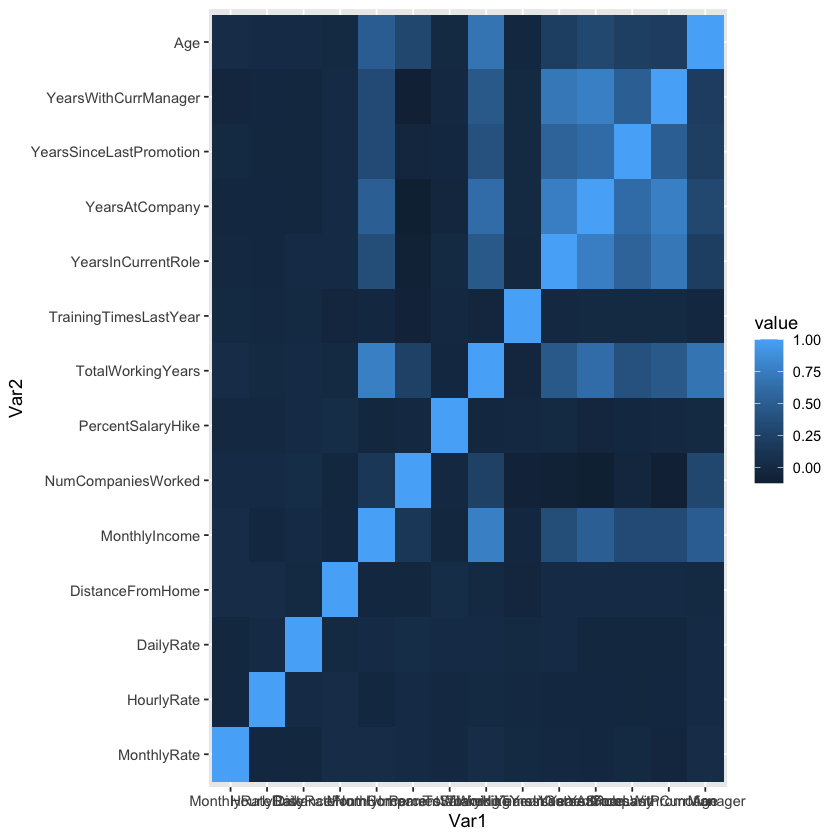

In [28]:
#Correlation Map (Not final)
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()

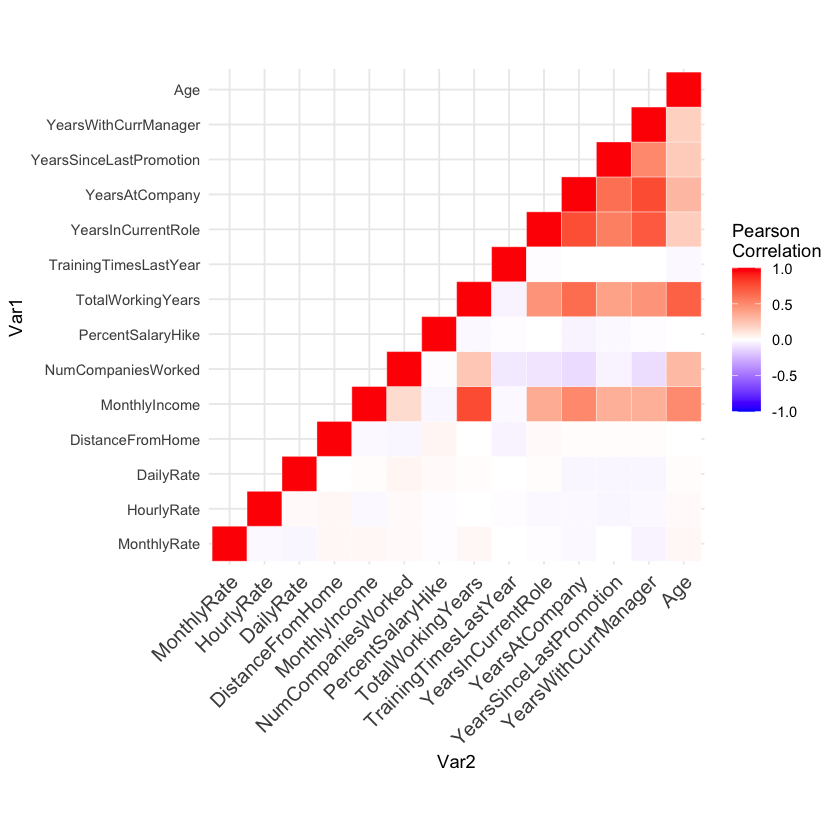

In [29]:
#Correlation Map With the correlation coefficients
upper_tri = get_upper_tri(cormat)

melted_cormat <- melt(upper_tri, na.rm = TRUE)

# Heatmap
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()

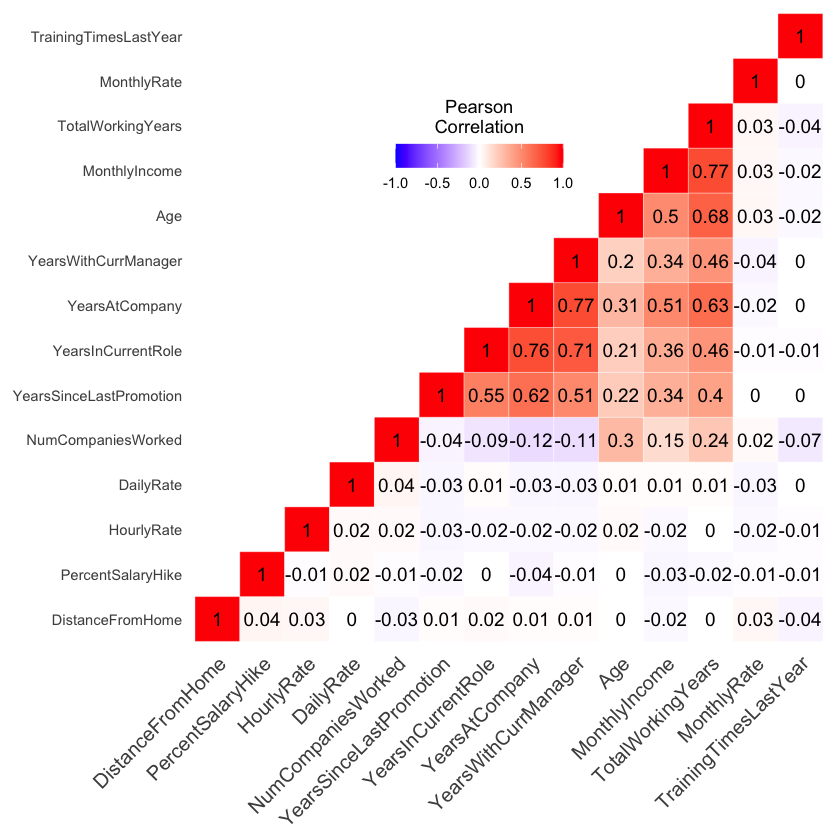

In [30]:
# Reorder the correlation matrix
cormat <- reorder_cormat(cormat)
upper_tri <- get_upper_tri(cormat)

# Melt the correlation matrix
suppressWarnings(melted_cormat <- melt(upper_tri, na.rm = TRUE))

# Create a ggheatmap
ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
    name="Pearson\nCorrelation") +
  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()
# Output the heatmap
ggheatmap + 
geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.7),
  legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))

## Salary vs Attrition EDA Review

There are many columns relating to salary. Namely:
Daily Rate			numeric ordinal	
Hourly Rate			numeric ordinal	

	
	
Monthly Income		numeric ordinal	
	
	
	
Note:	Standard Hours = 80		
numeric ordinal	
	
		Percent Salary Hike		numeric ordinal	
	
		Monthly Rate				numeric  ordinal

Were eliminated as a they were determined to be redundant columns during pre-processing.



Simple visualisations of the data will be created to view which column best describes salary.

A summary of the Daily Rate data 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  102.0   465.0   802.0   802.5  1157.0  1499.0 

 plot 1a has been plotted 
 
There is a little variation in Daily Rate but no clear pattern on first inspection 


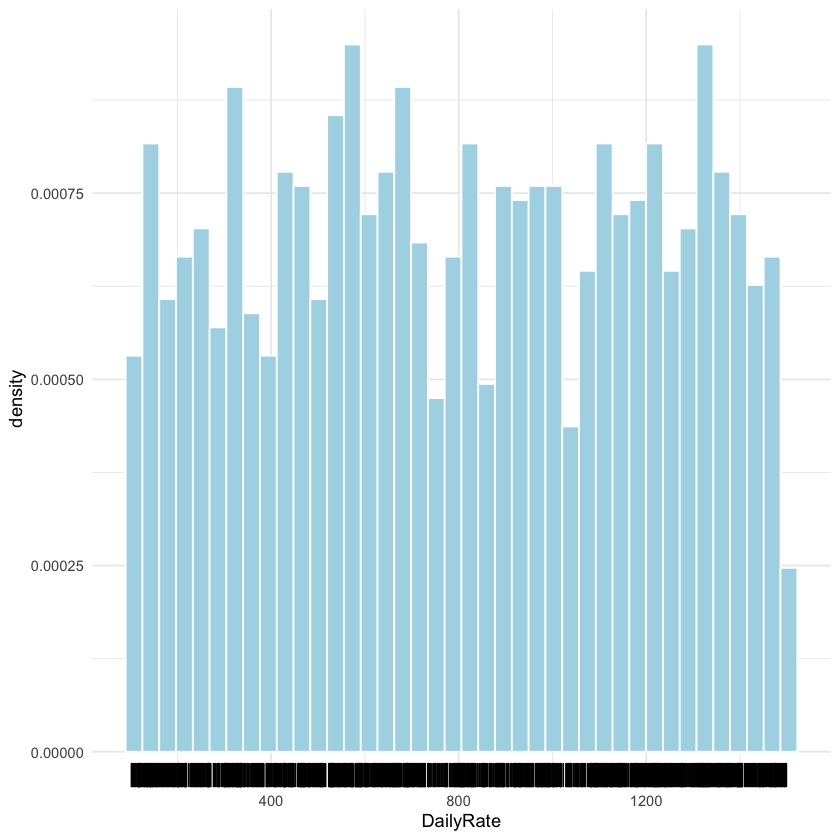

In [31]:
# 1a) DailyRate
cat("A summary of the Daily Rate data \n")
print(summary(salaryDataset$DailyRate))

# plot
plot1a<-ggplot(data = salaryDataset, mapping = aes(x=DailyRate)) + 
  geom_histogram(aes(y=..density..),fill="lightblue",color="white",bins=40) + 
  geom_rug() +
  labs(x='DailyRate') +
  theme_minimal()

print(plot1a)
cat("\n plot 1a has been plotted \n \n")

cat("There is a little variation in Daily Rate but no clear pattern on first inspection \n")

A summary of the Hourly Rate data 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.00   48.00   66.00   65.89   83.75  100.00 

 plot 1b has been plotted 
 
There doesn't seem to be a pattern in Hourly Rate data that 
needs to be investigated further 
 


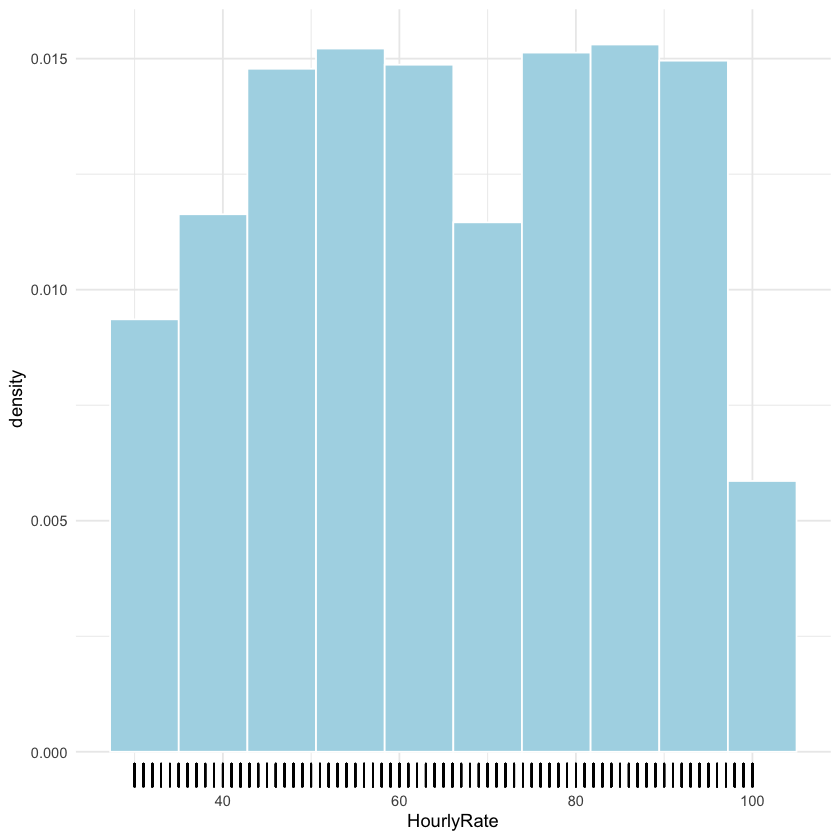

In [32]:
# 1b) HourlyRate
cat("A summary of the Hourly Rate data \n")
print(summary(salaryDataset$HourlyRate))

# plot
plot1b<-ggplot(data = salaryDataset, mapping = aes(x=HourlyRate)) + 
  geom_histogram(aes(y=..density..),fill="lightblue",color="white",bins=10) + 
  geom_rug() +
  labs(x='HourlyRate') +
  theme_minimal()

print(plot1b)
cat("\n plot 1b has been plotted \n \n")

cat("There doesn't seem to be a pattern in Hourly Rate data that \n")
cat("needs to be investigated further \n \n")

A summary of the Monthly Income data 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1009    2911    4919    6503    8379   19999 

 plot 1c has been plotted 
 
From this, can conclude that Monthly income has the most variation 
in its data, meaning it can best represent the variation in employee 
salary. 

 MonthlyIncome is the salary-related field we would like to explore further. 


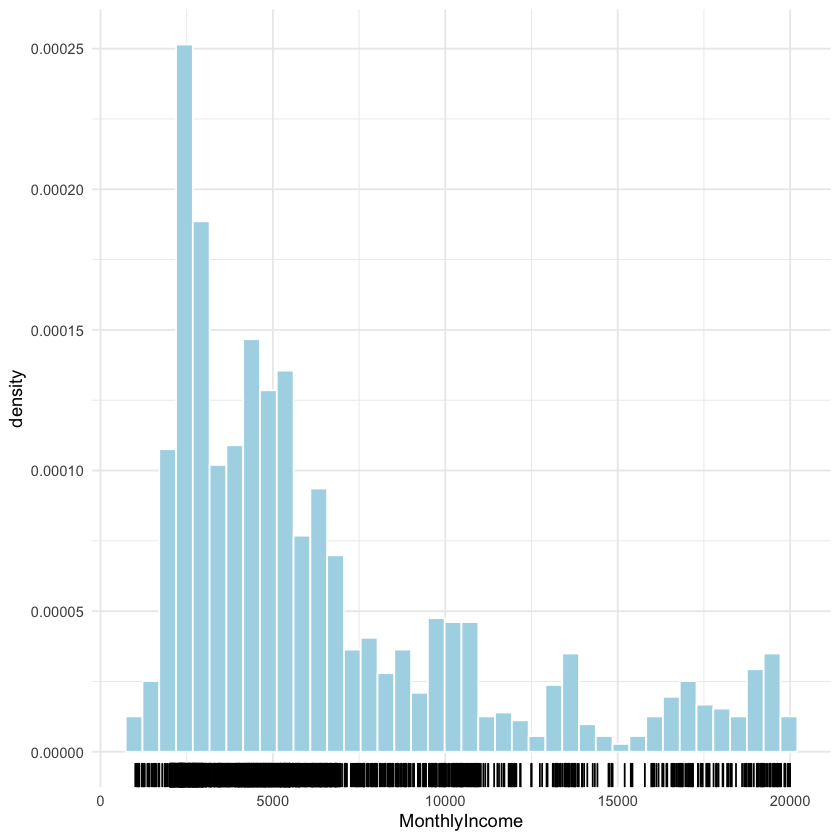

In [33]:
# 1c) MonthlyIncome
cat("A summary of the Monthly Income data \n")
print(summary(salaryDataset$MonthlyIncome))

# plot
plot1c<-ggplot(data = salaryDataset, mapping = aes(x=MonthlyIncome)) + 
      geom_histogram(aes(y=..density..),fill="lightblue",color="white",bins=40) + 
      geom_rug() +
      labs(x='MonthlyIncome') +
      theme_minimal()

print(plot1c)
cat("\n plot 1c has been plotted \n \n")

cat("From this, can conclude that Monthly income has the most variation \n")
cat("in its data, meaning it can best represent the variation in employee \n")
cat("salary. \n")

cat("\n MonthlyIncome is the salary-related field we would like to explore further. \n")

Having chosen the best column for salary (and considering the heatmap of relevant columns in the pre-processing section above), we will look at the Salary-Attrition relationship.

We can take a closer look at the data points within MonthlyIncome 

 plot 2a has been plotted 
 
And how the data points within MonthlyIncome begin to split by Attrition 


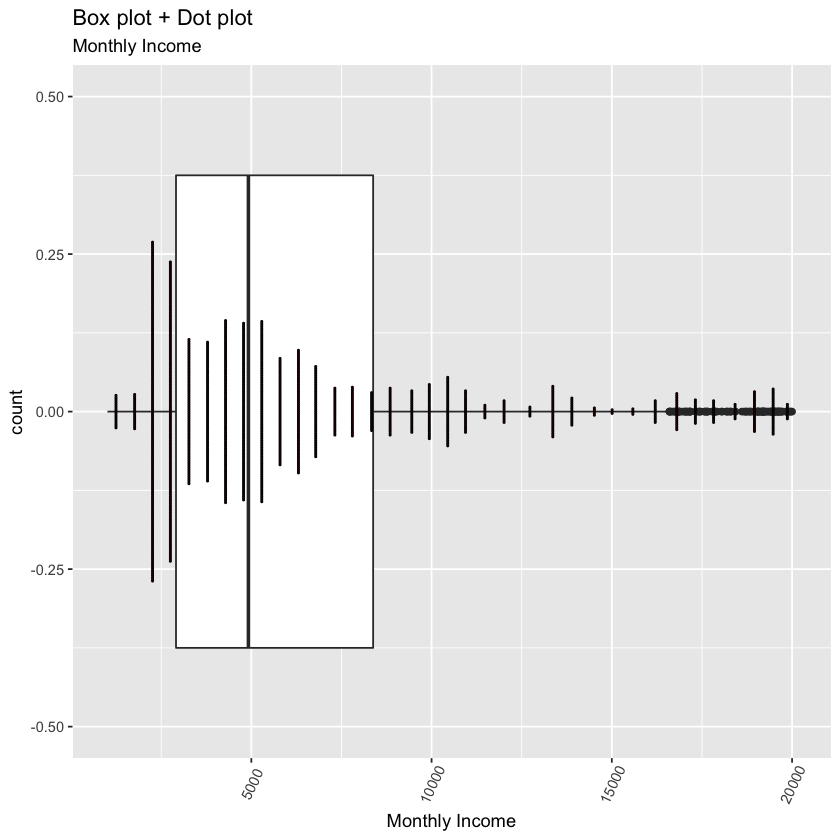


 plot 2b has been plotted 
 
But let's visualise this better by Sorting MonthlyIncome into bins
Monthly Income data sorted into bins of 2k: 
  0-2   2-4   4-6   6-8  8-10 10-12 12-14 14-16 16-18 18-20 
   33   509   372   175   100    86    53    16    57    69 


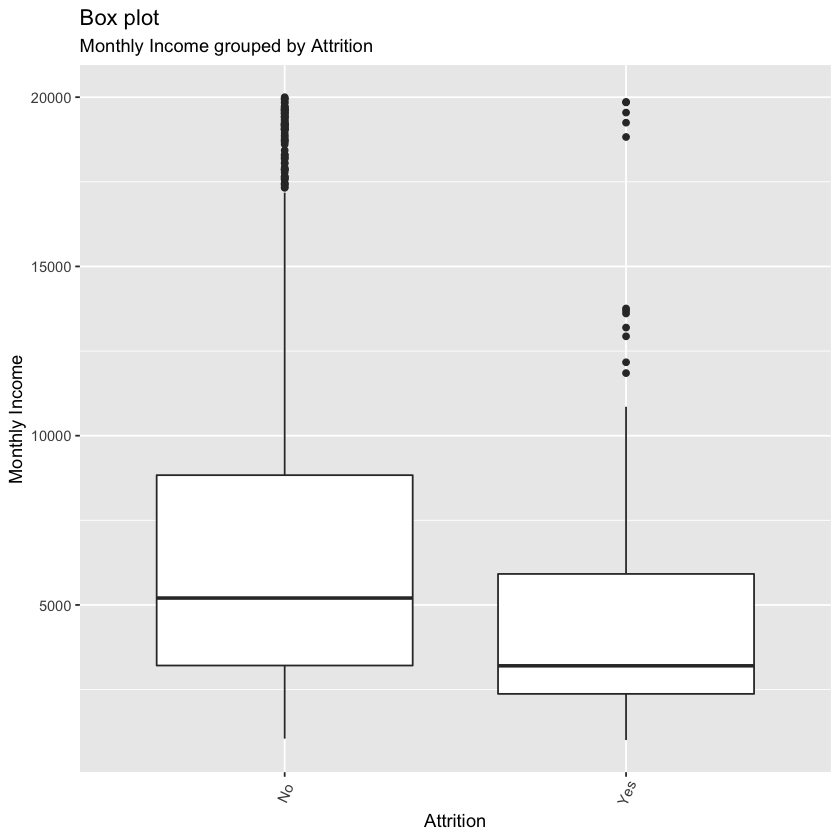


 plot 2c has been plotted 


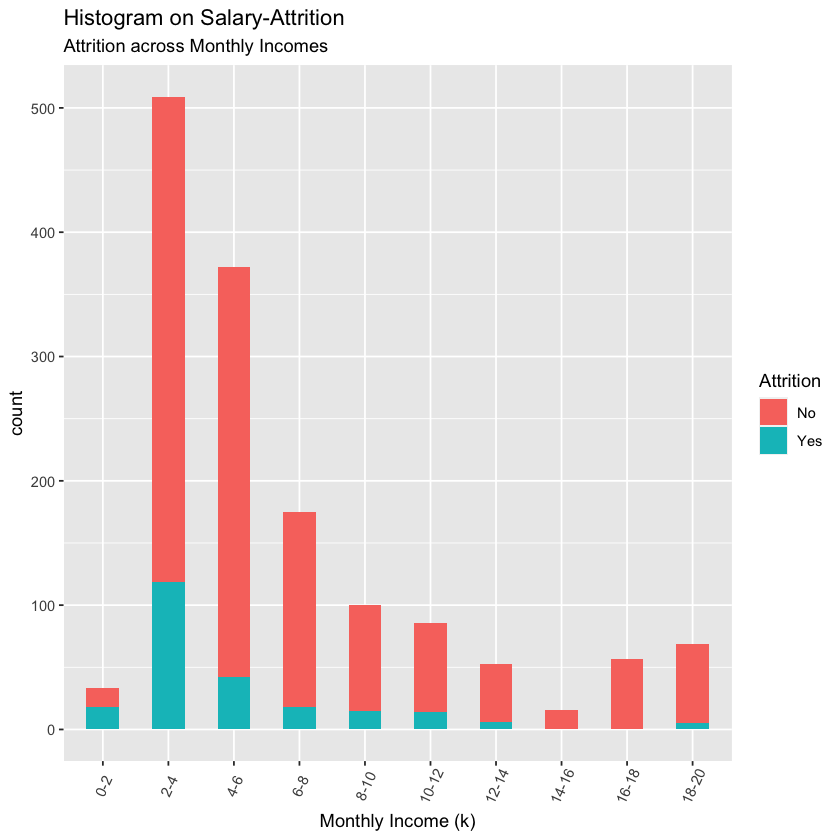

In [34]:
# 2a) MonthlyIncome & Attrition
cat("We can take a closer look at the data points within MonthlyIncome \n")

# plot
plot2a <- ggplot(salaryDataset, aes(MonthlyIncome)) +
  geom_boxplot() + 
  geom_dotplot(binaxis='x', 
               stackdir='center', 
               dotsize = .1, 
               fill="red",
               binwidth=500) +
  theme(axis.text.x = element_text(angle=65, vjust=0.6)) + 
  labs(title="Box plot + Dot plot", 
       subtitle="Monthly Income",
       theme_classic(),
       x="Monthly Income")

print(plot2a)
cat("\n plot 2a has been plotted \n \n")

cat("And how the data points within MonthlyIncome begin to split by Attrition \n")

# plot
plot2b <- ggplot(salaryDataset, aes(Attrition, MonthlyIncome)) +
  geom_boxplot() + 
  theme(axis.text.x = element_text(angle=65, vjust=0.6)) + 
  labs(title="Box plot", 
       subtitle="Monthly Income grouped by Attrition",
       theme_classic(),
       x="Attrition",
       y="Monthly Income")

print(plot2b)
cat("\n plot 2b has been plotted \n \n")

cat("But let's visualise this better by Sorting MonthlyIncome into bins\n")

# set up cut-off values 
bins <- c(0,2000,4000,6000,8000,10000,12000,14000,16000,18000,20000)
# name the bins
tags <- c("0-2","2-4", "4-6", "6-8", "8-10", "10-12","12-14", "14-16","16-18", "18-20")
# sort values into bins
group_tags <- cut(salaryDataset$MonthlyIncome, 
                  breaks=bins, 
                  include.lowest=TRUE, 
                  right=FALSE, 
                  labels=tags)

# inspect bins
cat("Monthly Income data sorted into bins of 2k: \n")
print(summary(group_tags))

# Histogram on Salary-Attrition
plot2c <- ggplot(salaryDataset, aes(group_tags)) +
  geom_bar(aes(fill=Attrition), width = 0.5) + 
  theme(axis.text.x = element_text(angle=65, vjust=0.6)) + 
  labs(title="Histogram on Salary-Attrition", 
       subtitle="Attrition across Monthly Incomes",
       x="Monthly Income (k)")

print(plot2c)
cat("\n plot 2c has been plotted \n")

Next, look at the factors that could have an effect on salary, such as:
Education 			1: Below College
					2. College
					3. Bachelors 
					4. Masters
					5. Doctors
Gender				categorical (Male OR Female)
TrainingTimesLastYear numeric ordinal

Now lets investigate which factors affect Monthly Income Salary 

 plot 3a has been plotted 


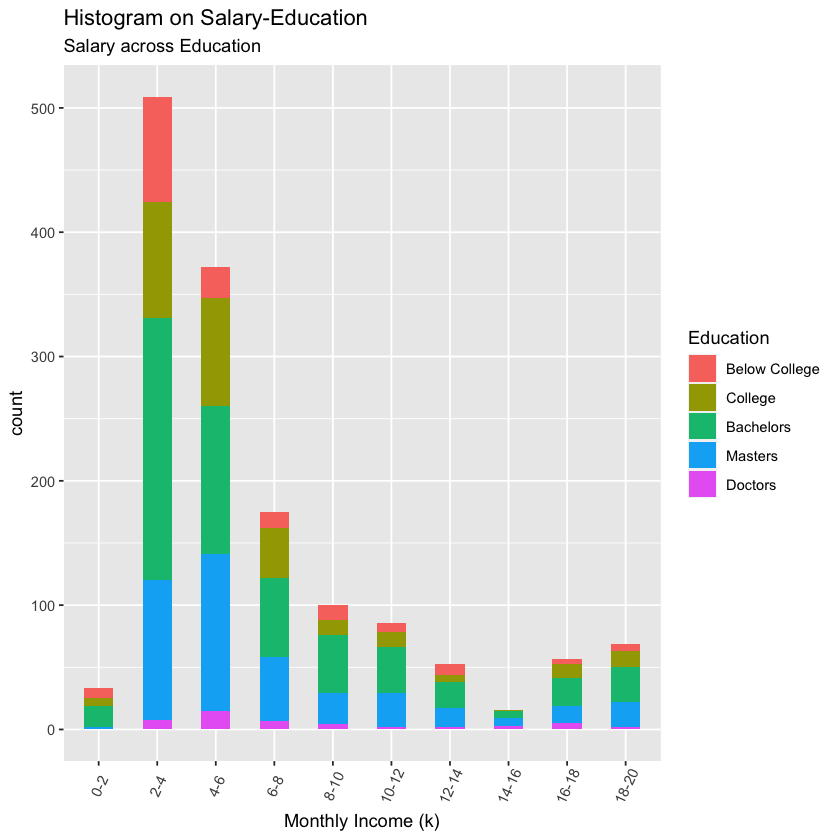


 plot 3b has been plotted 


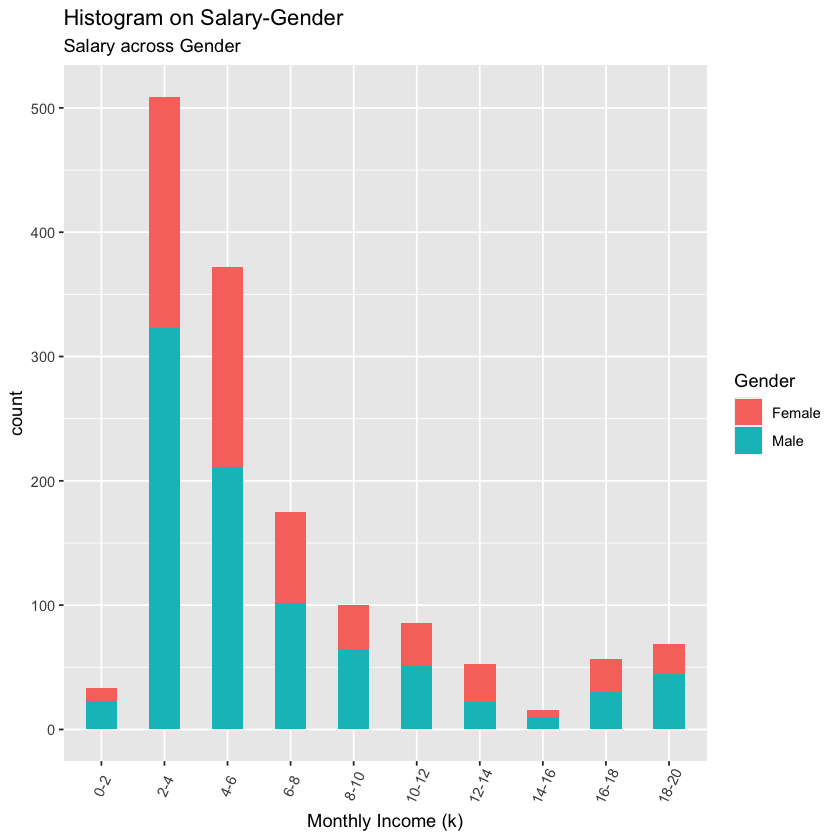


 plot 3c has been plotted 
A summary of the Training data 
  0   1   2   3   4   5   6 
 54  71 547 491 123 119  65 


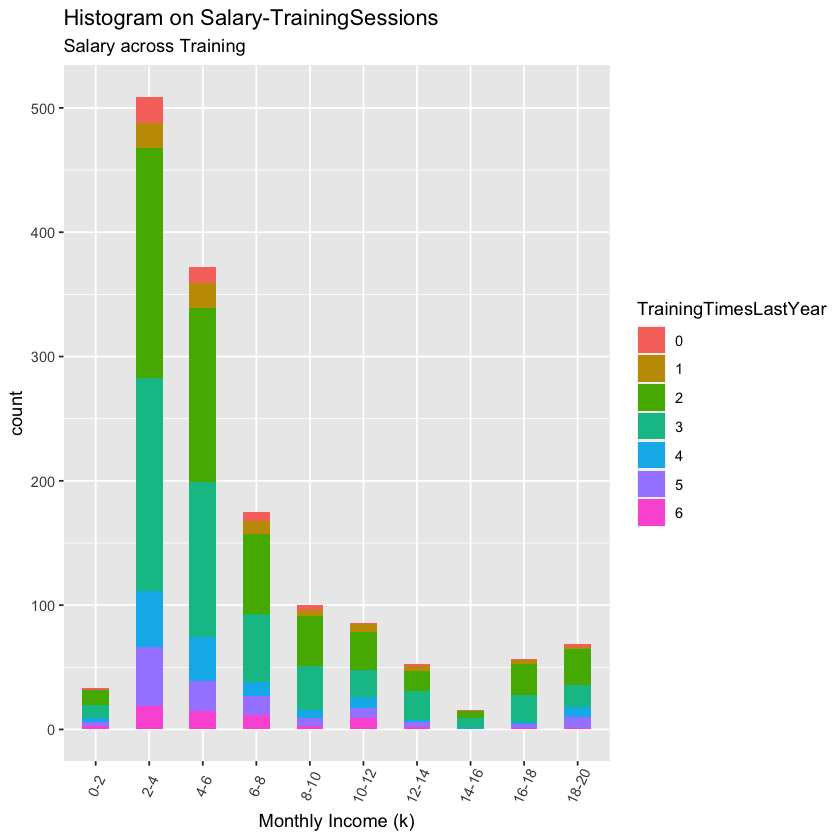

In [35]:
cat("Now lets investigate which factors affect Monthly Income Salary \n")

salaryDataset$Education <- factor(salaryDataset$Education, labels=c("Below College", "College", "Bachelors", "Masters","Doctors"))

# Histogram on Salary-Education
plot3a <- ggplot(salaryDataset, aes(group_tags)) +
  geom_bar(aes(fill=Education), width = 0.5) + 
  theme(axis.text.x = element_text(angle=65, vjust=0.6)) + 
  labs(title="Histogram on Salary-Education", 
       subtitle="Salary across Education",
       x="Monthly Income (k)")
#+ scale_color_discrete(name="Level of Education", labels=c("1 Below College", "College", "Bachelors",
#                              "Masters","Doctors")

print(plot3a)
cat("\n plot 3a has been plotted \n")

# Histogram on Salary-Gender
plot3b <- ggplot(salaryDataset, aes(group_tags)) +
  geom_bar(aes(fill=Gender), width = 0.5) + 
  theme(axis.text.x = element_text(angle=65, vjust=0.6)) + 
  labs(title="Histogram on Salary-Gender", 
       subtitle="Salary across Gender",
       x="Monthly Income (k)")


print(plot3b)
cat("\n plot 3b has been plotted \n")

salaryDataset$TrainingTimesLastYear <- as.factor(salaryDataset$TrainingTimesLastYear)

# Histogram on a Salary-TrainingSessions
plot3c <- ggplot(salaryDataset, aes(group_tags)) +
  geom_bar(aes(fill=TrainingTimesLastYear), width = 0.5) + 
  theme(axis.text.x = element_text(angle=65, vjust=0.6)) + 
  labs(title="Histogram on Salary-TrainingSessions", 
       subtitle="Salary across Training",
       x="Monthly Income (k)")


print(plot3c)
cat("\n plot 3c has been plotted \n")

cat("A summary of the Training data \n")
print(summary(salaryDataset$TrainingTimesLastYear))

## Distance vs Attrition EDA Review

Does distance from home to office a factor in company attrition rate. To commence the procedure, key columns were retained and a new dataframe was created appropriately. To determine which columns were necessary, a procedural approach was undertaken, whereby specified columns were retained, based upon the category one belongs to. 

The next procedure attached focused on converting string labels into a format that would be comprehensive as a statistical value. As illustrated in the block below, these labels were converted to numbers in the case that this data was to be used for the purposes of predictions, post attrition.

Following the above accomplishment, an initial visualisation was plotted to comprehend the correlation between business travel and attrition rate in general. In order to achieve the following, the values collected from the original data set consisting of Business Travel were plotted against one another, with the results showing the following: 

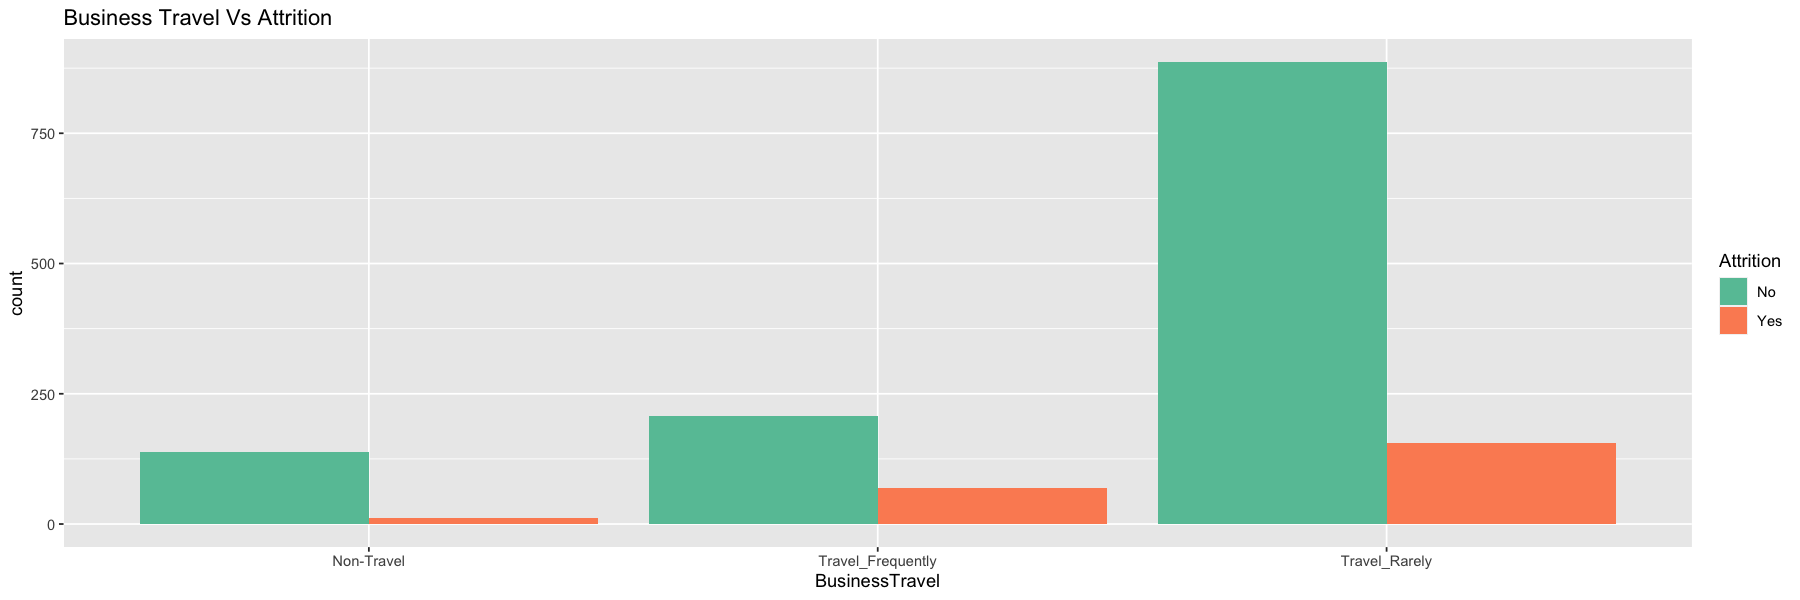

In [36]:
#load necessary libraries
library(ggplot2)
#create line plot for each column in data frame

#Initial examination of bar chart for atttrition vs DistanceFromHome
options(repr.plot.width = 15, repr.plot.height = 5)
ggplot(df, aes (x=BusinessTravel  )) + geom_bar(aes(fill= Attrition  )  ,position = 'dodge' )  + 
  ggtitle("Business Travel Vs Attrition") +
  scale_fill_brewer(palette="Set2")



Based on the above data presented, those who travel rarely for a business travel are more likely to leave the firm in comparison to non-travellers or those who travel at a frequent rate. However, with consideration to ratio for those wishing to leave against those not wishing to leave, it can be shown that the split between individuals who travel frequently have approximately 1:4 chance of leaving the firm. 

Following on, to support future visuals, field were collected from the initial dataframe, and moved to lists, as shown in the code block below. 

In [37]:
AgeList <- list(df$Age)
AttritionList <- list(df$Attrition)
DistanceList <- list (df$DistanceFromHome)

Similarly, a visualistion was later conducted, to comprehend the correlation between the travel distance for an employee against the attrition rate. We felt this to be one of the crucial elements as distance can have an impact, and wanted to understand if the two attributes shared a correlation. 

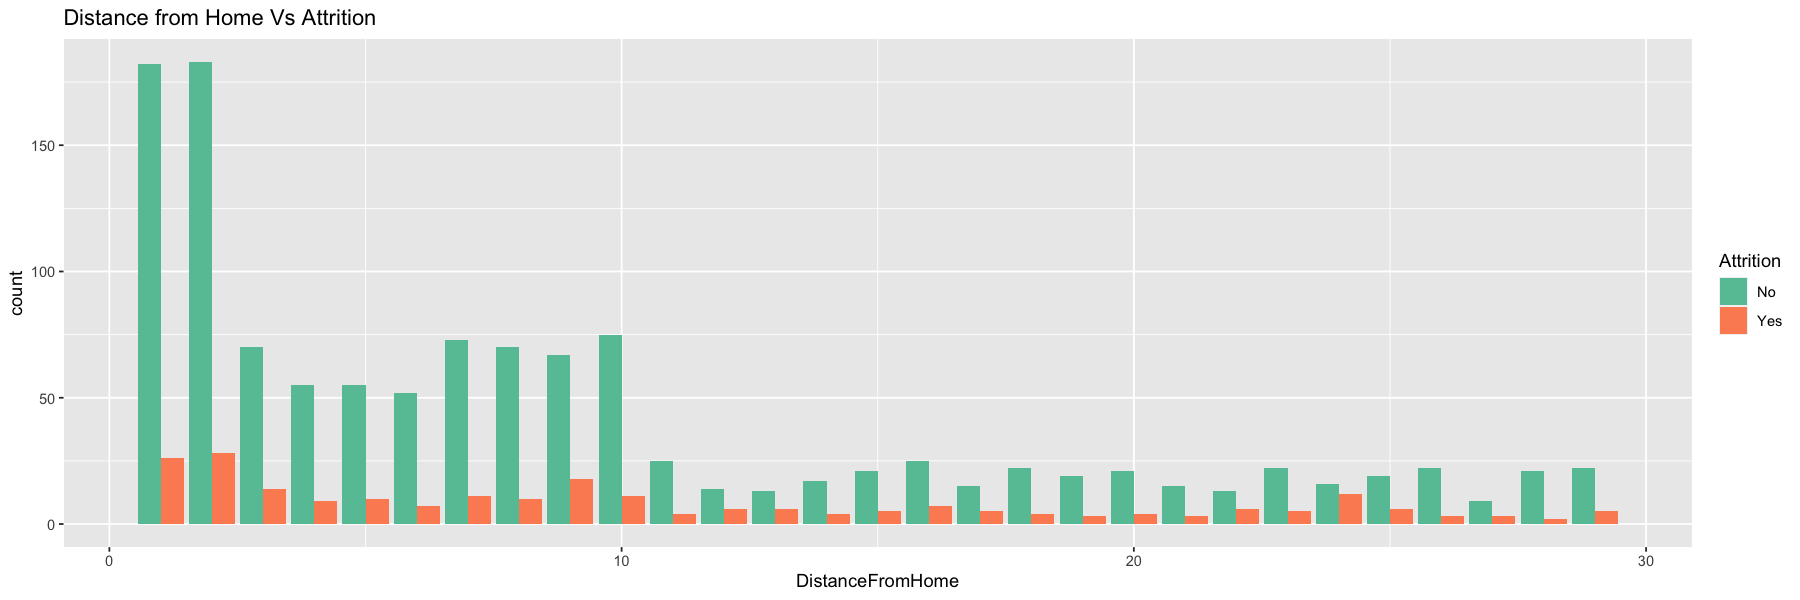

In [38]:
#load necessary libraries
library(ggplot2)
#create line plot for each column in data frame

#Initial examination of bar chart for atttrition vs DistanceFromHome
options(repr.plot.width = 15, repr.plot.height = 5)
ggplot(df, aes (x=DistanceFromHome  )) + geom_bar(aes(fill= Attrition  )  ,position = 'dodge' )  + 
  ggtitle("Distance from Home Vs Attrition") +
  scale_fill_brewer(palette="Set2")



Based on the generated results presented demonstrate that the correlation between distance of travel vs attrition is one of low consideration. If the results are to be analysed, the pattern of positive attrition is across the range of values present. Additionally, the values of attrition for the response of "no" are greater if the distance from home to work is lower, and presented for the range between 0-10.

### Attrition/Total Working Years Relationship 

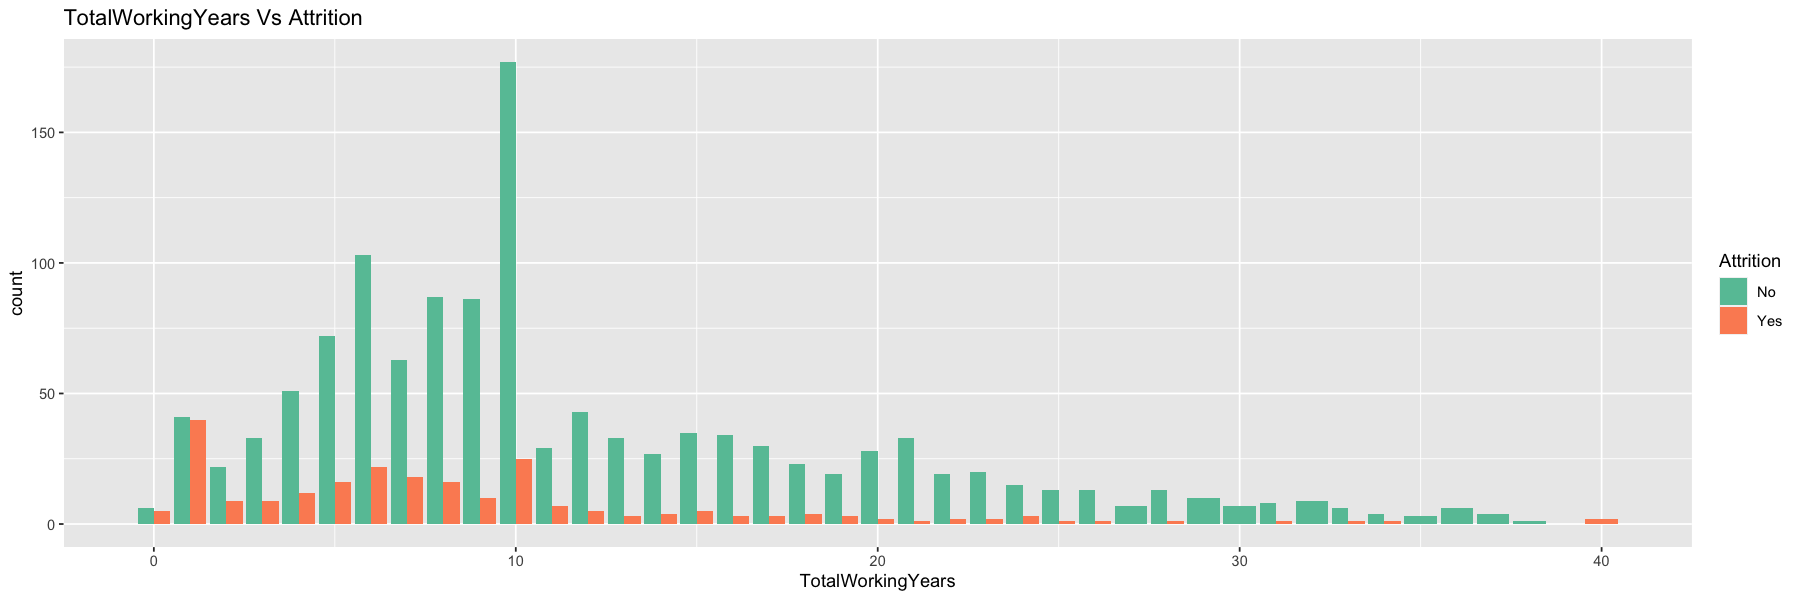

In [39]:
#Initial examination of bar chart for atttrition vs TotalWorking Years
options(repr.plot.width = 15, repr.plot.height = 5)# customize height and width 

#Plot
ggplot(df, aes (x=TotalWorkingYears  )) + geom_bar(aes(fill= Attrition  )  ,position = 'dodge' )  + 
  ggtitle("TotalWorkingYears Vs Attrition") +
  scale_fill_brewer(palette="Set2")

From the barplot above we see a clear trend where employees are most likely to attrition within their first year of work with an almost equal number of people who attrition vs those who stayed . After ten years of working with the company attrition levels drop significantly to rates close to 0

### Attrition/Department Relationship

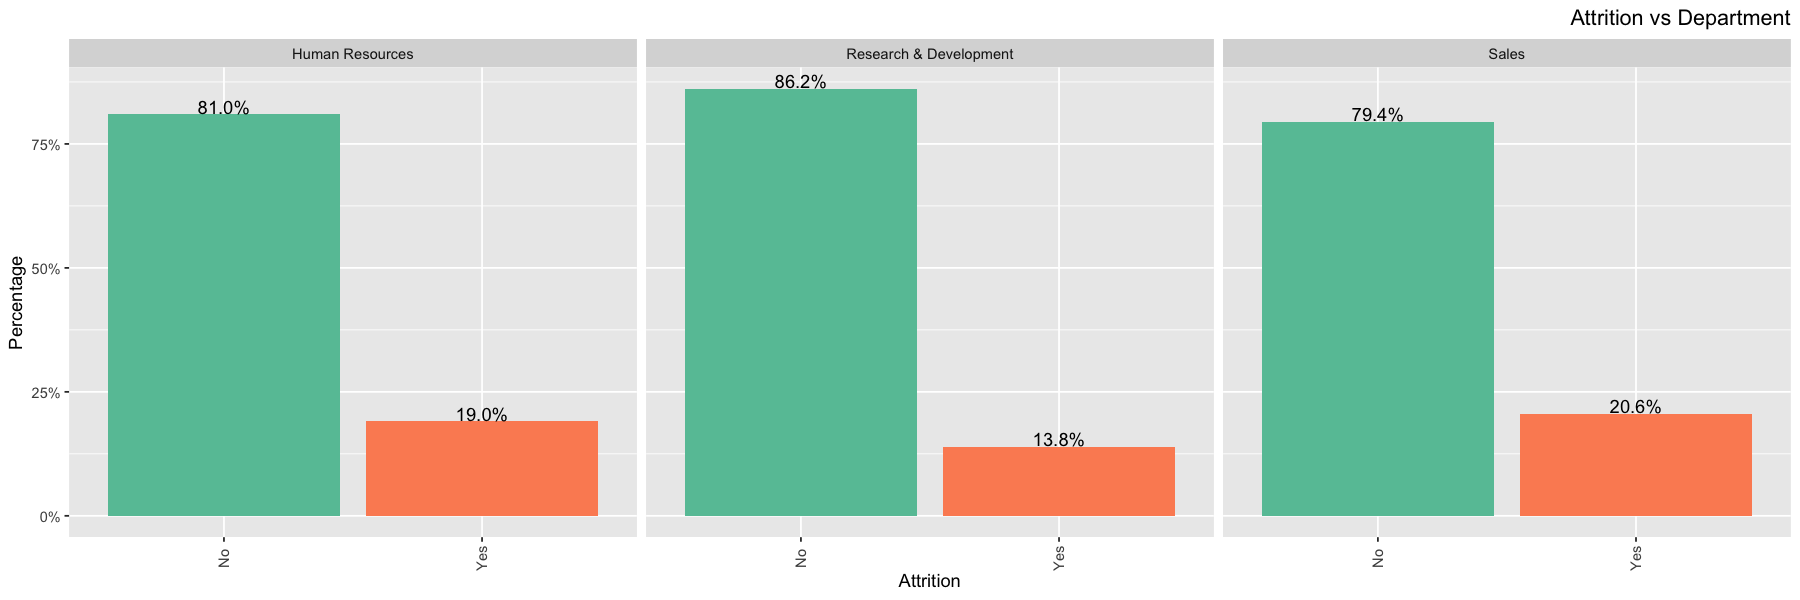

In [40]:
#create line plot for each column in data frame

#Initial examination of bar chart for atttrition vs DistanceFromHome
options(repr.plot.width = 15, repr.plot.height = 5)
ggplot(df,aes(x=Attrition,group=Department))+
  geom_bar(aes(y=after_stat(prop),fill=factor(..x..)),stat="count")+
  theme(axis.text.x=element_text(angle=90,vjust=0.5),legend.position="none",plot.title=element_text(size=13,hjust=1))+
  labs(x="Attrition",title="Attrition vs Department")+ facet_grid(~Department)+
  geom_text(aes(label = scales::percent(after_stat(prop)), y = after_stat(prop) ),stat= "count",vjust =-.1) +
  scale_y_continuous(labels=scales::percent) +
  ylab("Percentage") +
  scale_fill_brewer(palette="Set2")

All  departments have similar attrition rates with the sales  department having the highest rates with 1 out of every 5 people leaving . 

### Attrition/Years Under Current Manager Relationship

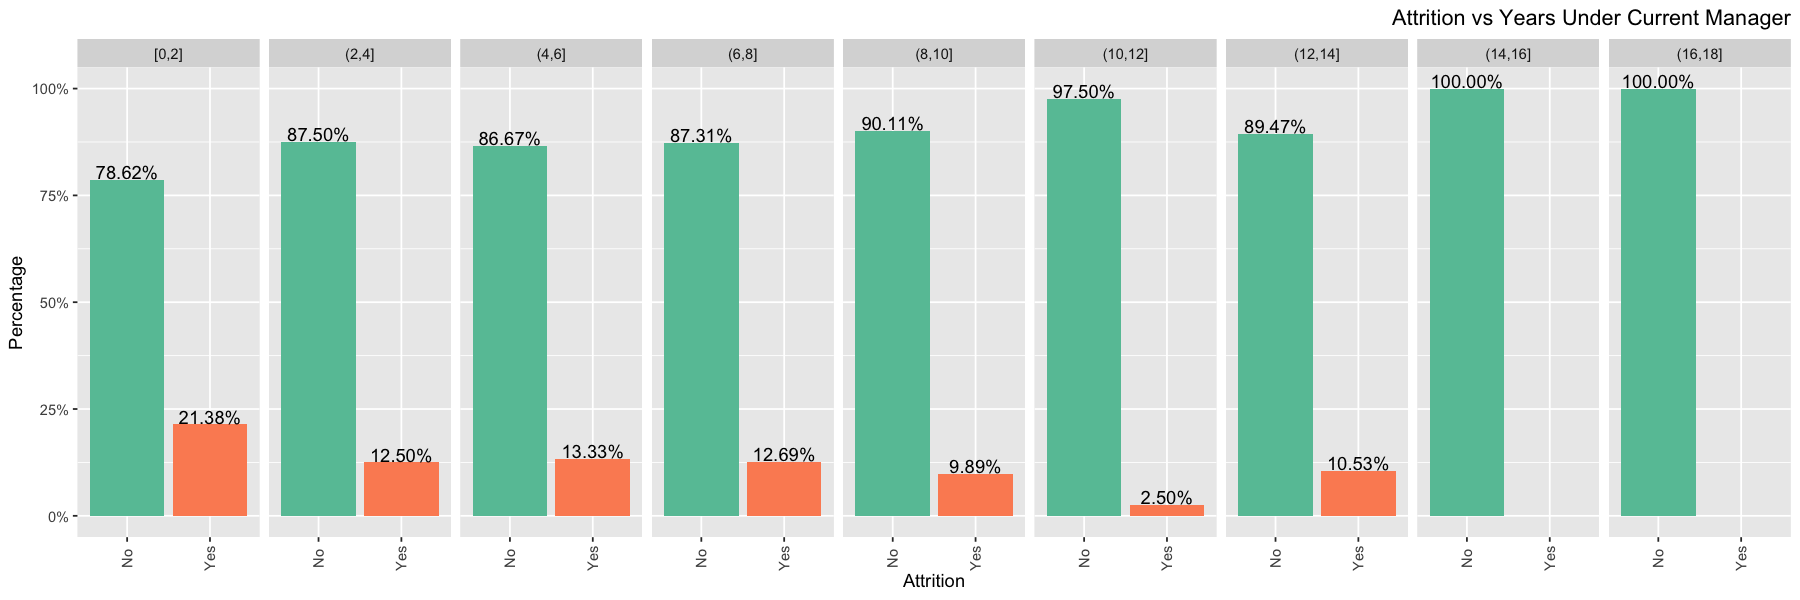

In [41]:
 #binning the values of yearswith current manager to create an understandable plot
 TimeUnderManagerAttr <-  data.frame(df$Attrition, df$YearsWithCurrManager)
TimeUnderManagerAttrBin <- data.frame(TimeUnderManagerAttr[,1],bin=cut(TimeUnderManagerAttr[,2],c(0,2,4,6,8,10,12,14,16,18, 20,25, 30, 35, 40, 50, 60),include.lowest=TRUE))

options(repr.plot.width = 15, repr.plot.height = 5)#customize height and width

#Plot
ggplot(TimeUnderManagerAttrBin,aes(x=TimeUnderManagerAttr[,1],group=bin))+
  geom_bar(aes(y=after_stat(prop),fill=factor(..x..)),stat="count")+
  theme(axis.text.x=element_text(angle=90,vjust=0.5),legend.position="none",plot.title=element_text(size=13,hjust=1))+
  labs(x="Attrition",title="Attrition vs Years Under Current Manager")+ facet_grid(~bin)+
  geom_text(aes(label = scales::percent(after_stat(prop)), y = after_stat(prop) ),stat= "count",vjust =-.1) +
  scale_y_continuous(labels=scales::percent) +
  ylab("Percentage") +
  scale_fill_brewer(palette="Set2")




The bar plot shows employees are more likely to leave the company within their 0-1st years of working . The years following the first bin have similar attrition rates until the 8th Year when the likelihood of not leaving breaks 90%. After spending a decade employee attrition rate plummets before surprisingly shooting up 400% in the 12th-13th year and then dropping to 0 in subsequent years.

## Satisfaction Vs Attrition Review

In [42]:
#Summarising fields from jobDataset
summary(jobSatDataset$EnvironmentSatisfaction)
summary(jobSatDataset$JobSatisfaction)
summary(jobSatDataset$RelationshipSatisfaction)
summary(jobSatDataset$WorkLifeBalance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   2.722   4.000   4.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   2.729   4.000   4.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   2.712   4.000   4.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   2.761   3.000   4.000 

### Initial Look into Satisfaction and Attrition

Observing the distribution of the satisfaction rating it can be seen that 'WorkLifeBalance' and 'EnvironmentSatisfaction' are exactly the same. whereas, 'JobSatisfaction' and 'RelationshipSatisfaction' have a similar distribution.

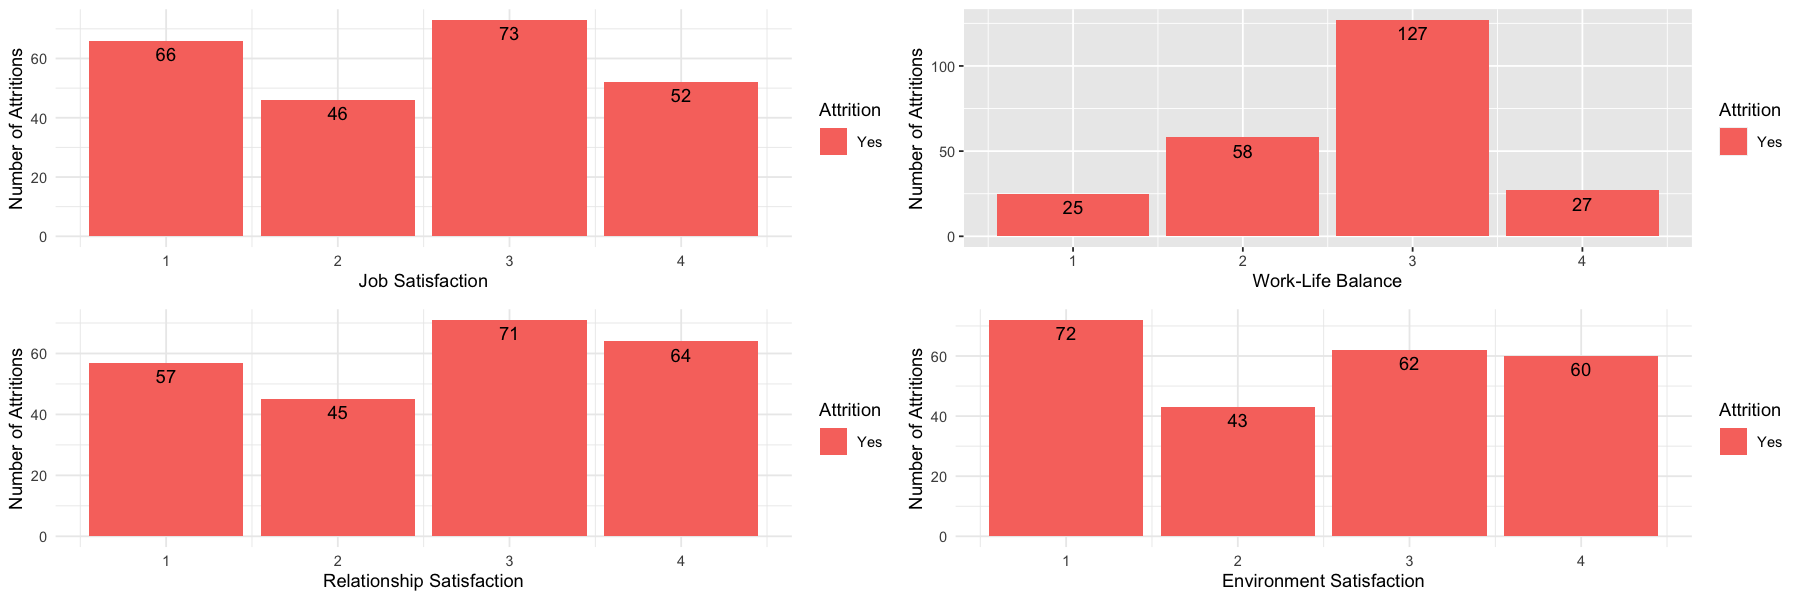

In [43]:
#Plots works life balance in relation to attrtition
wlbAttrition<- attritionEqualsYes %>%
    group_by(WorkLifeBalance, Attrition) %>%
    tally() %>% ## summarize data using tally function
    #BAR Plot
    ggplot(aes(x = WorkLifeBalance, y = n,fill=Attrition)) +
    geom_bar(stat = "identity") +
    labs(x="Work-Life Balance", y="Number of Attritions")+
    geom_text(aes(label = n), vjust = 1.5, position = position_dodge(0.9))

#Plots job satisfaction in relation to attrtition
 jbAttrition<- attritionEqualsYes %>%
    group_by(JobSatisfaction, Attrition) %>%
    tally() %>% ## summarize data using tally function
    ## BAR PLOT
    ggplot(aes(x = JobSatisfaction, y = n,fill=Attrition)) +
    geom_bar(stat = "identity") +
    theme_minimal()+
    labs(x="Job Satisfaction", y="Number of Attritions")+
    geom_text(aes(label = n), vjust = 1.5, position = position_dodge(0.9))

#Plots Relationship satisfaction in relation to attrtition
relAttrition<- attritionEqualsYes %>%
    group_by(RelationshipSatisfaction, Attrition) %>%
    tally() %>%## summarize data using tally function
    #BAR Plot
    ggplot(aes(x = RelationshipSatisfaction, y = n,fill=Attrition)) +
    geom_bar(stat = "identity") +
    theme_minimal()+
    labs(x="Relationship Satisfaction", y="Number of Attritions")+
    geom_text(aes(label = n), vjust = 1.5, position = position_dodge(0.9))

    #Plots Environment satisfaction in relation to attrition
  envirAttrition<- attritionEqualsYes %>%
    group_by(EnvironmentSatisfaction, Attrition) %>%
    tally() %>% ## summarize data using tally function
    #BAR Plot
    ggplot(aes(x = EnvironmentSatisfaction, y = n,fill=Attrition)) +
    geom_bar(stat = "identity") +
    theme_minimal()+
    labs(x="Environment Satisfaction", y="Number of Attritions")+
    geom_text(aes(label = n), vjust = 1.5, position = position_dodge(0.9))

#Take all graphs and put into columns using arange function
  grid.arrange(jbAttrition, wlbAttrition, relAttrition, envirAttrition, ncol=2)

### Relationship Satisfaction

`summarise()` has grouped output by 'ManagerYearsLabel'. You can override using
the `.groups` argument.


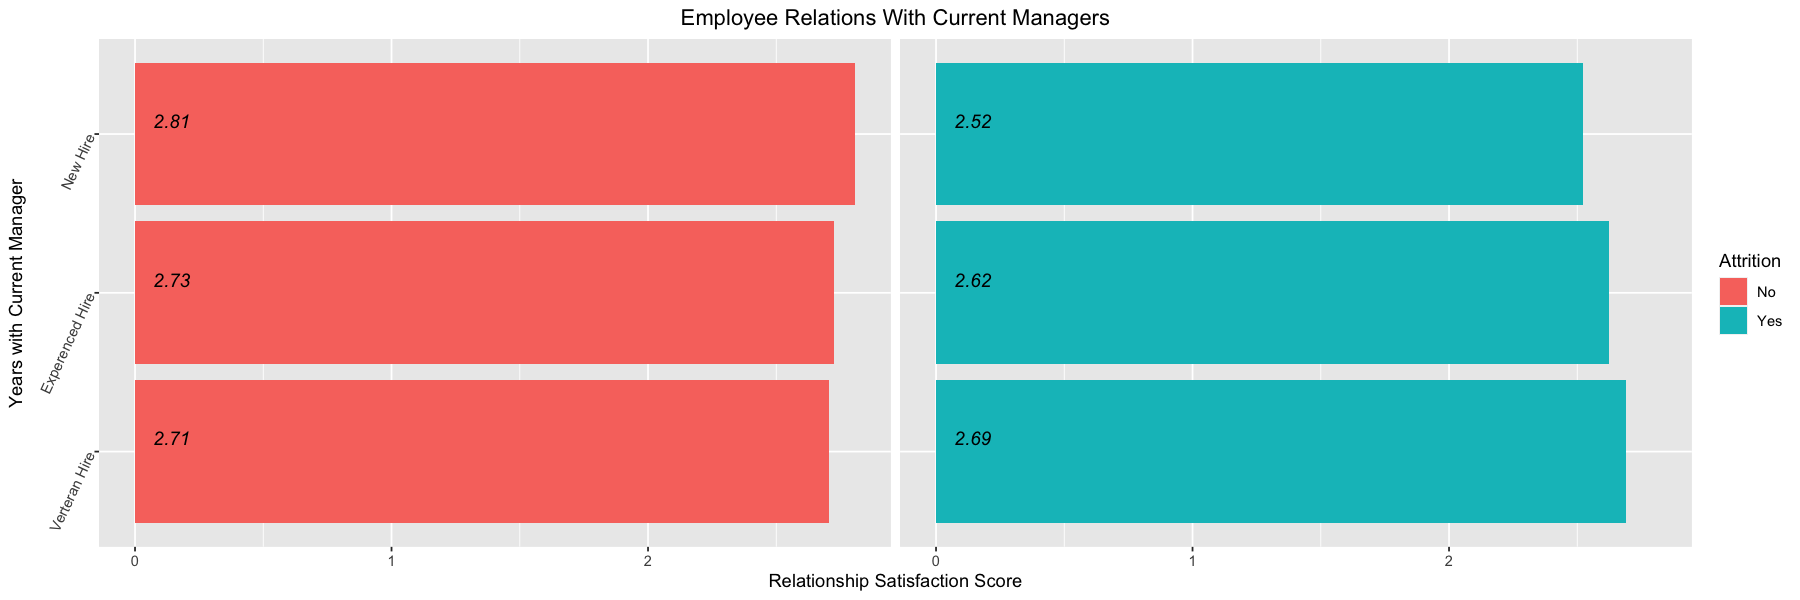

In [44]:
#Replace values in jobSatDataset based on specified condition 
jobSatDataset$ManagerYearsLabel <-
    ifelse(
      jobSatDataset$YearsWithCurrManager <= 1,
      'New Hire',
      ifelse(
        jobSatDataset$YearsWithCurrManager > 1 &
          jobSatDataset$YearsWithCurrManager <= 4,
        'Experenced Hire',
        'Verteran Hire'
      )
    )
  
   #Plotting Managers years label ,relationship satisafction with attrition 
  relAttrPlot <-
    #select columns from job satisafaction and group by manager years label
    jobSatDataset %>% select(ManagerYearsLabel, RelationshipSatisfaction, Attrition) %>%
    group_by(ManagerYearsLabel, Attrition) %>% 
    
    #Calculating mean relationship satisfaction and placing it into the averageSat
    summarise(averageSat = mean(RelationshipSatisfaction)) %>% 
    
    #plotting bar graphs
    ggplot(aes(x=fct_reorder(ManagerYearsLabel ,-averageSat), y=averageSat, fill=Attrition)) + 
    geom_bar(stat="identity", position="dodge") + facet_wrap(~Attrition) +
    geom_text(aes(x=ManagerYearsLabel, y=0, label= paste0(round(averageSat,2))),
              hjust=-0.5, vjust=-0.5, size=4,colour="black", fontface="italic",
              angle=360) + coord_flip() + 
    theme(legend.position="right", strip.background = element_blank(), 
          strip.text.x = element_blank(), plot.title=element_text(hjust=0.5),
          axis.text.y = element_text(angle = 65)) + 
    labs(x="Years with Current Manager",y="Relationship Satisfaction Score", 
         title="Employee Relations With Current Managers")
  
  #outputing bar graphs  
  relAttrPlot

### Work Life Balance

The Research and Development seem to have the highest attrition when work life balance is concerned.

`summarise()` has grouped output by 'Department'. You can override using the
`.groups` argument.


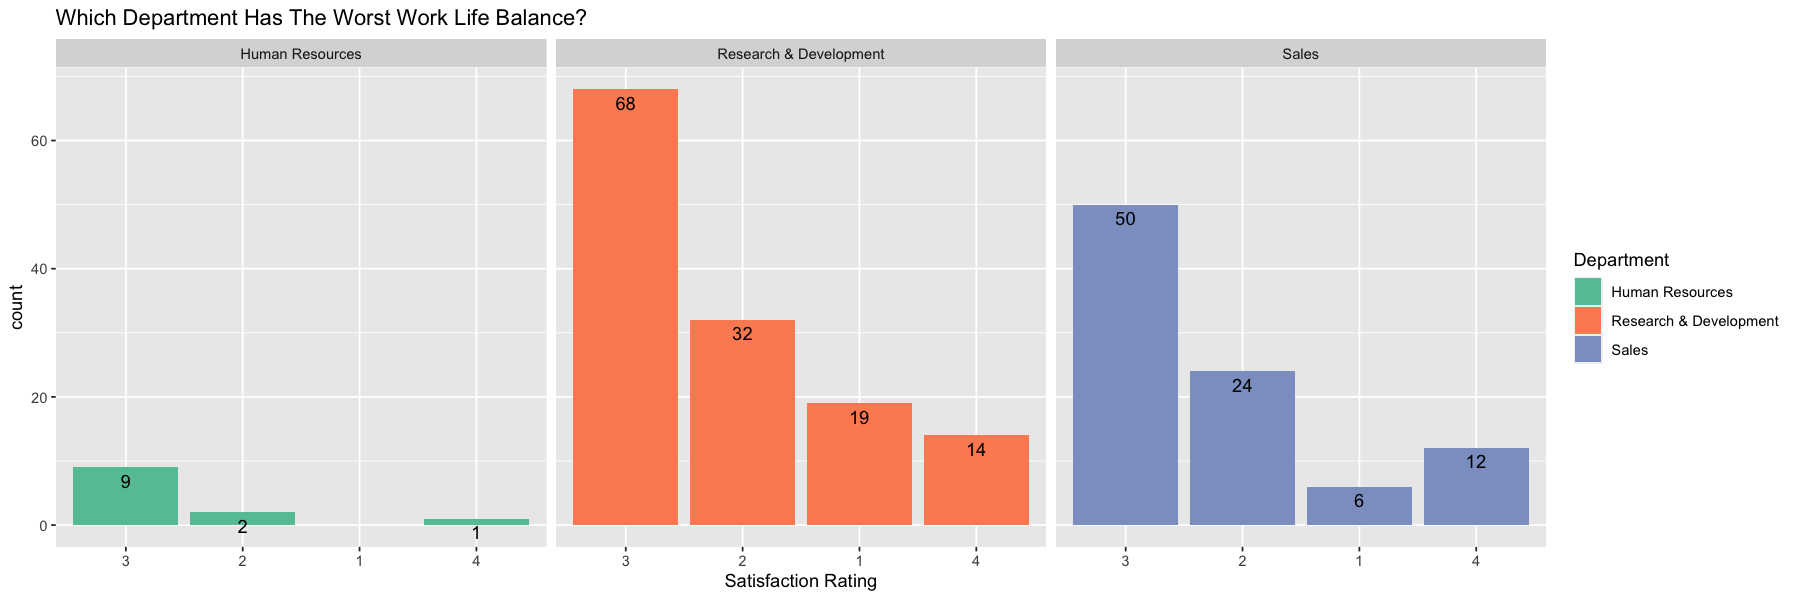

In [45]:
#turning work life into factor datatype
attritionEqualsYes$WorkLifeBalance <- as.factor(attritionEqualsYes$WorkLifeBalance)
  
    #Selecting Department and WorkLifeBalance 
    wlbDepartment <- attritionEqualsYes %>% select(Department, WorkLifeBalance) %>% 
    group_by(Department, WorkLifeBalance) %>%
    
    #Creating count for WorkLifeBalance
    summarize(count=n()) %>% 

    #Plotting bar graphs
    ggplot(aes(x=fct_reorder(WorkLifeBalance, -count), y=count, fill=Department)) + 
    geom_bar(stat='identity') +
    labs(x = "Satisfaction Rating", title = "Which Department Has The Worst Work Life Balance?") + 
    facet_wrap(~Department) +
    geom_text(aes(label = count), vjust = 1.5, position = position_dodge(0.9)) +
    scale_fill_brewer(palette = "Set2")
    
    #Displaying bar graphs
    wlbDepartment

A high concentration of overtime can be seen in the Research & Development department, which could indicate a correlation between 'OverTime' and 'WorkLifeBalance'. It can be observed that Research & Development has the worst work life balance however, the lowest attrition percentage. 

`summarise()` has grouped output by 'OverTime'. You can override using the
`.groups` argument.


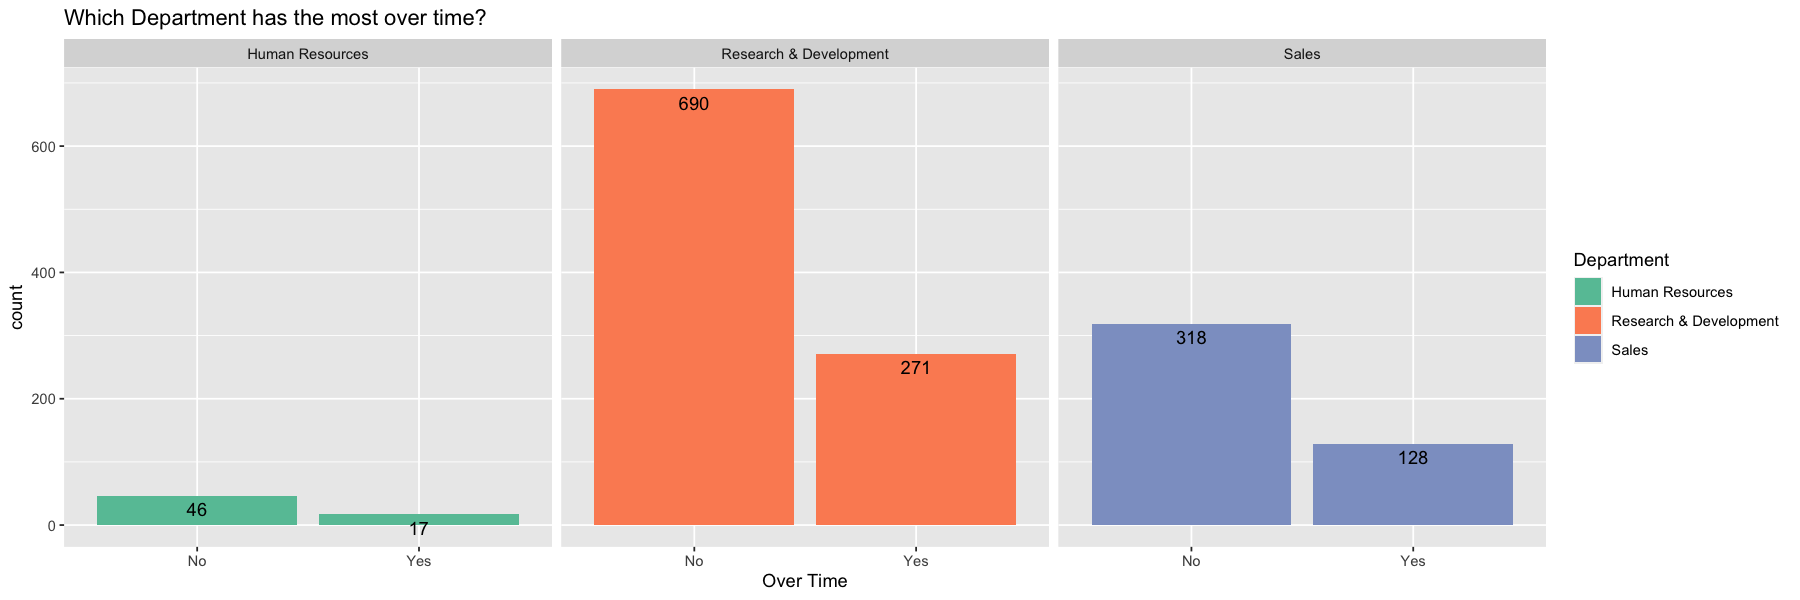

In [46]:
    #Selecting OverTime and Department
    overDepartment <- jobSatDataset %>% select(OverTime, Department) %>% 
    group_by(OverTime, Department) %>%
    
    #Creating a count for OverTime
    summarize(count=n()) %>% 
    ggplot(aes(x=fct_reorder(OverTime, -count), y=count, fill=Department)) + 
    geom_bar(stat='identity') +
    labs(x = "Over Time", title = "Which Department has the most over time?") + 
    facet_wrap(~Department) +
    geom_text(aes(label = count), vjust = 1.5, position = position_dodge(0.9)) +
    scale_fill_brewer(palette = "Set2")
  
  overDepartment

### Environment Satisfaction

`summarise()` has grouped output by 'Department'. You can override using the
`.groups` argument.


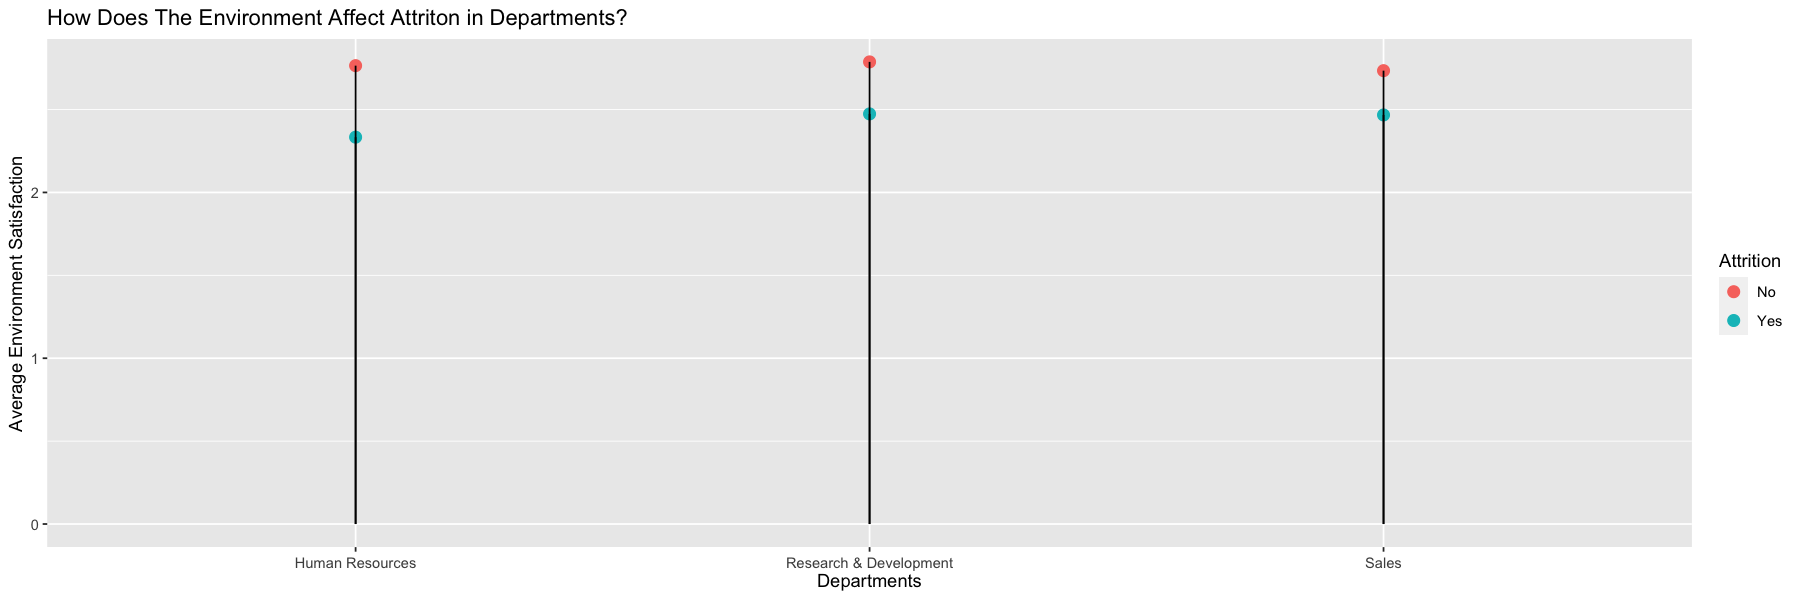

In [47]:
#Selecting EnvironmentSatisfaction, Department and Attrition
envDepartAttr <- jobSatDataset %>% select(EnvironmentSatisfaction, Department, Attrition) %>% 
    group_by(Department, Attrition) %>% 
    #Summarizing the EnvironmentSatisfaction
    summarize(averageEnvSat=mean(EnvironmentSatisfaction)) %>%
    
    #Plotting a lollipop graph
    ggplot(aes(x=Department, y=averageEnvSat)) + 
      geom_point(aes(color=Attrition), size=3) + 
    geom_segment(aes(x=Department, 
                     xend=Department, 
                     y=0, 
                     yend=averageEnvSat)) + 
    labs(title='How Does The Environment Affect Attriton in Departments?',
         x = 'Departments',
         y='Average Environment Satisfaction') + 
    theme(axis.text.x = element_text(angle=0, vjust=0.5))
  
  #Displaying the graphs
  envDepartAttr

`summarise()` has grouped output by 'JobRole'. You can override using the
`.groups` argument.


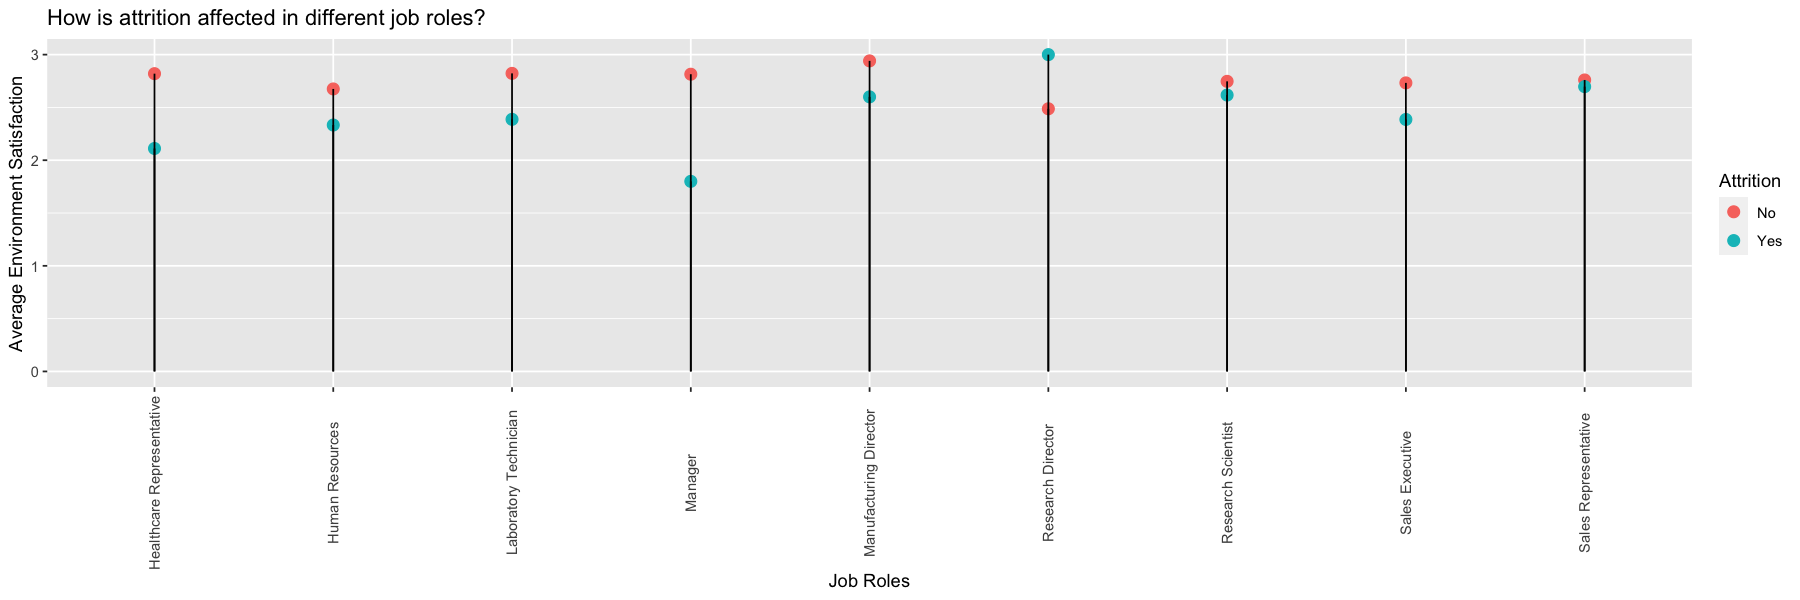

In [48]:
#Selecting EnvironmentSatisfaction, JobRole and Attrition
  envRoleAttr <- jobSatDataset %>% select(EnvironmentSatisfaction, JobRole, Attrition) %>% 
    group_by(JobRole, Attrition) %>% 
    
    #Calculating the mean for EnvironmentSatisfaction
    summarize(averageEnvSat=mean(EnvironmentSatisfaction))%>%
    
    #Plotting a lollipop graph
    ggplot(aes(x=JobRole, y=averageEnvSat)) + 
    geom_point(aes(color=Attrition), size=3 ) +
    geom_segment(aes(x=JobRole,
                     y=0,
                     xend=JobRole, 
                     yend=averageEnvSat)) + 
    labs(title='How is attrition affected in different job roles?',
         x = 'Job Roles', y = 'Average Environment Satisfaction') + 
    theme(axis.text.x = element_text(angle=90, vjust=0.5)) +
            scale_fill_brewer(palette = "Set3")

    #Dsiplaying the graphs
    envRoleAttr

The limited range of distribution in performance rating doesn't tell how much overtime effects an employee.

### Performance Rating

`summarise()` has grouped output by 'PerformanceRating'. You can override using
the `.groups` argument.


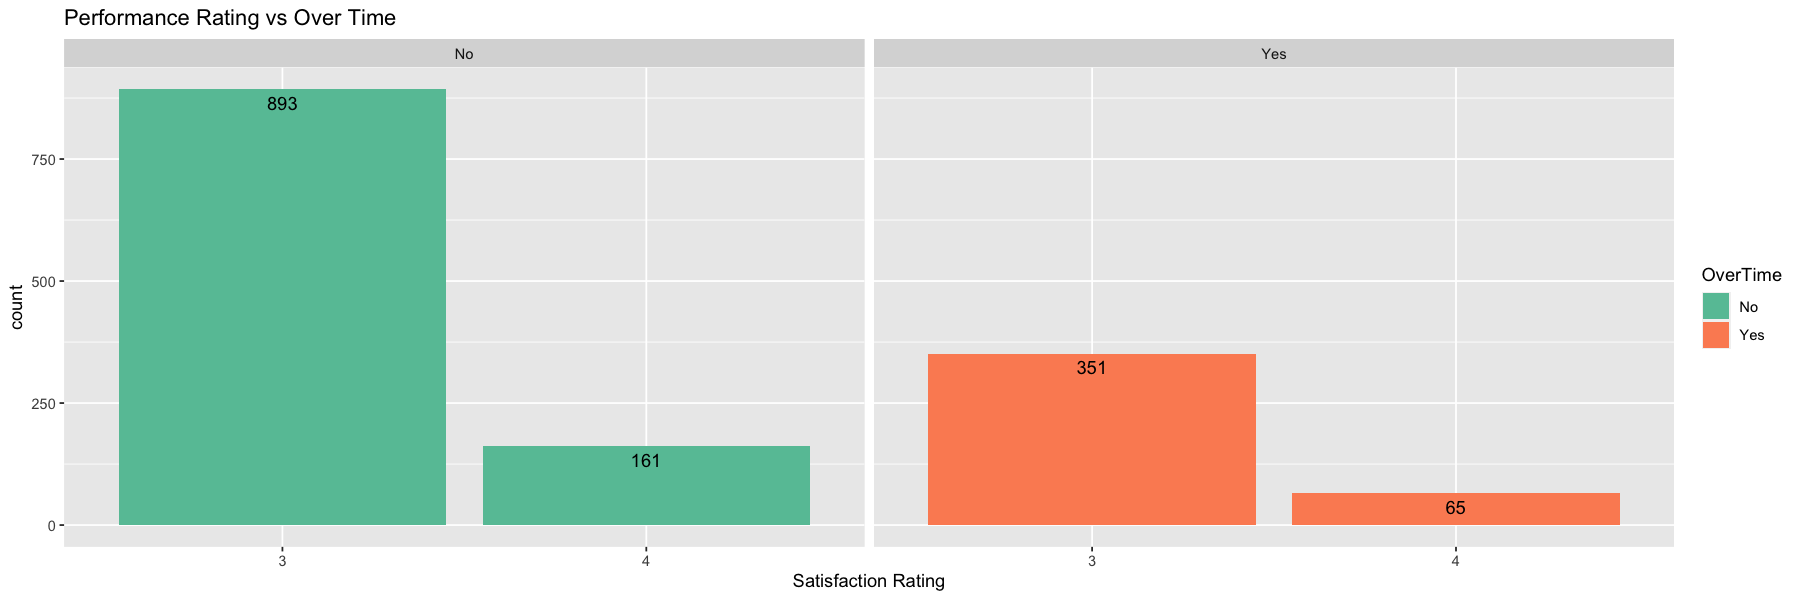

In [49]:
#Changing Datatypes into Factors
jobSatDataset$OverTime <- as.factor(jobSatDataset$OverTime)
jobSatDataset$PerformanceRating <- as.factor(jobSatDataset$PerformanceRating)
  
  #Selecting PerformanceRating and OverTime
  perfOvertimePlot <- jobSatDataset %>% select(PerformanceRating, OverTime) %>% 
    group_by(PerformanceRating, OverTime) %>%
    
    #Creating a count for PerformanceRating
    summarize(count=n()) %>% 
    
    #Plotting bar graphs for PerformanceRating
    ggplot(aes(x=fct_reorder(PerformanceRating, -count), y=count, fill=OverTime)) + 
    geom_bar(stat='identity') +
    labs(x = "Satisfaction Rating", title = "Performance Rating vs Over Time") + 
    facet_wrap(~OverTime) +
    geom_text(aes(label = count), vjust = 1.5, position = position_dodge(0.9)) +
    scale_fill_brewer(palette = "Set2")
    
    #Displaying bar graphs
    perfOvertimePlot

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d1eff50-eacf-4908-a16f-518105206e20' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>